In [11]:
import sys
from my_weapon import *
from tqdm import tqdm_notebook as tqdm
from fake_identify import Are_you_IRA
import matplotlib
from collections import Counter
# matplotlib.rcParams["font.size"] = 14
# sns.set_style("darkgrid")

ira_c = sns.color_palette("coolwarm", 8)[7]
all_c = sns.color_palette("coolwarm", 8)[0]
sns.set(style="darkgrid", font_scale=1.2)
Putin = Are_you_IRA()

In [22]:
from infomap import Infomap

def findCommunities(G, mt=1):
    """
    Partition network with the Infomap algorithm.
    Annotates nodes with 'community' id and return number of communities found.
    """
    infomapWrapper = Infomap(f"--two-level --silent --markov-time {mt} -N 10")

#     print("Building Infomap network from a NetworkX graph...")
    
    for e in G.edges(data=True):
        e = (G.node[e[0]]["id"], G.node[e[1]]["id"])
#         e = (G.node[e[0]]["id"], G.node[e[1]]["id"])
        # print(e)
        infomapWrapper.addLink(*e)

#     print("Find communities with Infomap...")
    infomapWrapper.run();

#     print("Found %d modules with codelength: %f" % (infomapWrapper.numTopModules(), infomapWrapper.codelength()))
    
    communities = {}
#     for node in infomapWrapper.iterTree():
#         print("{} {}".format(node.path(), node.physicalId))

    ix_to_name = {G.node[name]["id"]: name for name in G.nodes()}
    # print(ix_to_name)

    for node in infomapWrapper.iterTree():
        if node.isLeaf():
            # f.write("{}\t{}\t{}\n".format(ix_to_name[node.physicalId], node.physicalId, node.moduleIndex()))
            communities[ix_to_name[node.physicalId]] = node.moduleIndex()
    
    nx.set_node_attributes(G, name='community_Infomap', values=communities)

    return G, communities, infomapWrapper.numTopModules(), infomapWrapper.codelength()

In [336]:
G = nx.read_gpickle("disk/ira-ret.gp")
# G

In [337]:
G.number_of_nodes(), G.number_of_edges()

(154366, 360265)

In [338]:
G = G.subgraph(max(nx.weakly_connected_components(G), key=len))

In [339]:
putin = Are_you_IRA()

for i, n in enumerate(G.nodes()):
    if putin.fuck(n):
        G.node[n]["IRA"] = 1
    else:
        G.node[n]["IRA"] = 0

In [340]:
G = G.to_undirected()

In [341]:
# cnt = 0

# for matlab
with open("data/ira-ret.net", "w") as f:
    f.write(f"*Vertices {G.number_of_nodes()}\n")
    for i, n in enumerate(G.nodes()):
        G.node[n]["id"] = i + 1
        f.write(f'{i+1} "{i+1}"\n')
    f.write("*Edges\n")
    
    for e in G.edges(data=True):
#         print(e)
        n1, n2 = e[0], e[1]
        f.write(f"{G.node[n1]['id']} {G.node[n2]['id']} 1\n")
    #     print(G.node[n])
                
G.number_of_nodes(), G.number_of_edges()

(154257, 359244)

In [274]:
G, comm, num, cl = findCommunities(G, mt=5)

from collections import Counter
cnt = Counter()
for k, v in comm.items():
    cnt[v] += 1
print(cnt.most_common(10))

json.dump(comm, open("data/ira-ret-community.json", "w"), indent=2)

# ira_rst["mentioning"] = get_G_char_IRA("disk/ira-men.gp")
# ira_rst["replying"] = get_G_char_IRA("disk/ira-rep.gp")
# ira_rst["quoting"] = get_G_char_IRA("disk/ira-quo.gp")

[(0, 120724), (2, 22731), (1, 7947), (6, 552), (22, 262), (20, 209), (7, 179), (4, 142), (13, 127), (129, 118)]


In [10]:
from collections import Counter
rst = []

for i in tqdm(np.arange(1, 11, 1)):
#     print(f"\n***** --markov-time ={i} *****")
    G, comm, n_mod, codelength = findCommunities(G, mt=i)
    cnt = Counter()
    for k, v in comm.items():
        cnt[v] += 1
    print("Size of top 10 communities:", [s for n, s in cnt.most_common(10)])
    rst.append([i, n_mod, codelength, cnt.most_common(10)])

Size of top 10 communities: [34097, 15849, 15446, 7733, 6776, 5321, 5286, 4753, 4659, 4393]
Size of top 10 communities: [133167, 7784, 6613, 1473, 1125, 823, 479, 358, 242, 173]
Size of top 10 communities: [143984, 6641, 1133, 484, 281, 169, 137, 136, 118, 117]
Size of top 10 communities: [144179, 7791, 617, 370, 169, 154, 138, 118, 101, 85]
Size of top 10 communities: [145117, 7823, 169, 169, 167, 159, 118, 117, 85, 83]
Size of top 10 communities: [153562, 169, 118, 85, 81, 42, 41, 37, 26, 21]
Size of top 10 communities: [153664, 254, 118, 42, 41, 37, 26, 20, 18, 10]
Size of top 10 communities: [153637, 169, 118, 85, 75, 42, 41, 37, 20, 12]
Size of top 10 communities: [153687, 256, 118, 73, 38, 37, 20, 12, 9, 7]
Size of top 10 communities: [153795, 258, 118, 38, 20, 12, 9, 7]


In [290]:
X = [r[0] for r in rst]
sns.set(style="white", font_scale=1.4)

Text(0, 0.5, 'Number of modules')

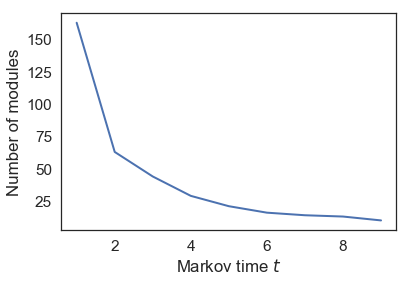

In [291]:
y = [r[1] for r in rst]
# print(y)
plt.plot(X, y, lw=2)
plt.xlabel("Markov time $t$")
plt.ylabel("Number of modules")
# plt.xscale("log")

Text(0, 0.5, 'Code length (bits)')

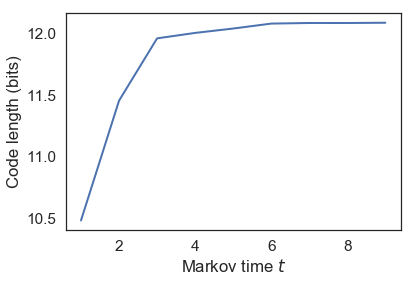

In [292]:
y = [r[2] for r in rst]
# print(y)
plt.plot(X, y, lw=2)
plt.xlabel("Markov time $t$")
plt.ylabel("Code length (bits)")
# plt.xscale("log")

Text(0, 0.5, 'Size of the largest module')

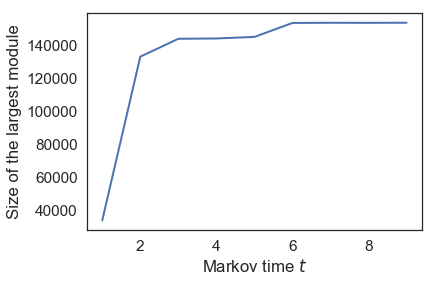

In [293]:
y = [r[3][0][1] for r in rst]
# print(y)
plt.plot(X, y, lw=2)
plt.xlabel("Markov time $t$")
plt.ylabel("Size of the largest module")
# plt.xscale("log")

In [294]:
import community

G = nx.Graph(G)
partition = community.best_partition(G)
# partition = community.best_partition(G, resolution=5)

In [295]:
cnt = Counter()
for n, c in partition.items():
    cnt[c] += 1 

In [296]:
cnt.most_common()

[(1, 49455),
 (5, 18030),
 (0, 16434),
 (9, 15082),
 (3, 13973),
 (7, 12572),
 (6, 8441),
 (4, 7774),
 (8, 7741),
 (2, 2718),
 (10, 1118),
 (13, 358),
 (14, 297),
 (17, 118),
 (15, 76),
 (11, 26),
 (16, 20),
 (18, 12),
 (12, 6),
 (19, 6)]

In [96]:
comm_nodes = {}

for n in G.nodes(data=True):
    c =  n[1]["community_Infomap"]
    if c not in comm_nodes:
        comm_nodes[c] = 0
    if n[1]["IRA"] == 1:
        comm_nodes[c] += 1

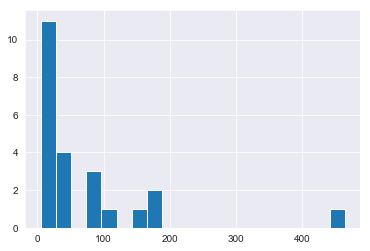

In [97]:
# 社团大小

d = pd.Series([v for v in cnt.values() if v < 1000])
# x, cdf, pdf = get_cdf_pdf(d, mini=1)
# plt.plot(x, pdf)
# plt.xscale("log")
d.hist(bins=20)

In [67]:
# for gephi

plot_these_nodes = []
keep_iras = []


for n in G.node(data=True):
#     if n[1]["community_Infomap"] in [0, 3, 23, 8, 6]:
#     if n[1]["community_Infomap"] in [0, 9, 2, 3, 4]:
    if n[1]["community_Infomap"] in [0, 1, 2]:
        if n[1]["IRA"] == 1:
            keep_iras.append(n[0])
        else:
            plot_these_nodes.append(n[0])
            
len(plot_these_nodes), len(keep_iras)

(151270, 287)

In [190]:
# random sampling for show
import random

plot_these_nodes = random.sample(plot_these_nodes, int(len(plot_these_nodes) * 0.1))
plot_these_nodes.extend(keep_iras)
G = G.subgraph(plot_these_nodes)
G = G.subgraph(max(nx.connected_components(G), key=len))

In [169]:
G = nx.Graph(G)

In [170]:
nx.write_gexf(G, "data/IRA-20190506.gexf")

### IRA关注于哪些社团？

In [ ]:
from collections import Counter

cnt = Counter()
for k, v in comm.items():
    if putin.fuck(k):
        cnt[v] += 1
    
cnt.most_common(100)

In [75]:
cnt = Counter()
for k, v in comm.items():
    cnt[v] += 1
    
print(cnt.most_common(50))
    
cnt[3], cnt[23], cnt[81], cnt[95], cnt[0]

[(0, 100991), (3, 7691), (23, 6912), (8, 6553), (6, 5060), (2, 3399), (11, 2288), (19, 1934), (1, 1743), (26, 1256), (9, 1129), (60, 1068), (14, 1051), (29, 1034), (27, 925), (4, 837), (39, 831), (28, 761), (62, 673), (25, 628), (21, 557), (61, 530), (45, 486), (52, 479), (43, 364), (81, 285), (5, 270), (65, 249), (7, 231), (56, 225), (55, 222), (40, 220), (57, 208), (64, 175), (69, 169), (44, 144), (42, 137), (24, 134), (35, 134), (50, 122), (16, 120), (95, 118), (17, 117), (22, 116), (87, 88), (10, 85), (34, 76), (31, 73), (15, 71), (12, 68)]


(7691, 6912, 285, 118, 100991)

[(3, 79),
 (23, 64),
 (81, 43),
 (95, 28),
 (0, 18),
 (5, 18),
 (67, 17),
 (105, 8),
 (25, 7),
 (11, 6)]
 
 专注3，23，84，0 三个社团，看看他们是否有不同的受众？
 
 (7691, 6910, 281, 118)

In [76]:
for n in G.nodes():
    print(n, G.node[n])
    break

4437444442 {'id': 0, 'community_Infomap': 0}


## 5. 构建交互网络!!

包括四种行为


In [455]:
G = nx.DiGraph()
G.add_edge(1, 2)
G.add_edge(2, 1)
G.number_of_nodes(), G.number_of_edges()

(2, 2)

In [456]:
n1 = nx.read_gpickle("disk/ira-ret.gp")
n2 = nx.read_gpickle("disk/ira-men.gp")
n3 = nx.read_gpickle("disk/ira-rep.gp")
n4 = nx.read_gpickle("disk/ira-quo.gp")

In [457]:
_n2 = n2.reverse()

In [459]:
G = nx.DiGraph()

G.add_edges_from(n1.edges)
# G.add_edges_from(n2.edges)
G.add_edges_from(_n2.edges)
G.add_edges_from(n3.edges)
G.add_edges_from(n4.edges)

# G = G.to_undirected()
print(G.number_of_nodes(), G.number_of_edges())
# G = G.subgraph(max(nx.weakly_connected_components(G), key=len))

G.remove_edges_from(G.selfloop_edges())
print(G.number_of_nodes(), G.number_of_edges())

179783 432532
179783 432429


In [460]:
putin = Are_you_IRA()

with open("disk/have_touched_IRA.txt", "w") as f:
    for node in G.nodes():
        if not Putin.fuck(node):
            f.write(node + "\n")
            
with open("data/first_layer_touch_IRA.txt", "w") as f:
    for i, n in enumerate(G.nodes()):
        if putin.fuck(n):
            G.node[n]["IRA"] = 1
        else:
            f.write(n + "\n")
            G.node[n]["IRA"] = 0

nx.write_gpickle(G, "data/ira-interaction.gp")

In [89]:
def save_for_matlab(G, out_name):
    print("change into undir and get the connected component")
    _G = G.to_undirected()
    _G = max(nx.connected_component_subgraphs(_G), key=len)
    print(_G.number_of_nodes(), _G.number_of_edges())

    with open(out_name, "w") as f:
        f.write(f"*Vertices {_G.number_of_nodes()}\n")
        for i, n in enumerate(_G.nodes()):
            _G.node[n]["id"] = i + 1
            f.write(f'{i} "{i}"\n')

        f.write("*Edges\n")
        for e in _G.edges(data=True):
    #         print(e)
            n1, n2 = e[0], e[1]
    #         f.write(f"{G.node[n1]['id']},{G.node[n2]['id']}\n")
            f.write(f"{_G.node[n1]['id']} {_G.node[n2]['id']} 1\n")
        #     print(G.node[n])
    return _G

In [61]:
G = nx.read_gpickle("data/ira-interaction.gp")

In [94]:
# for matlab

G = save_for_matlab(G, "data/ira-int-1-undir.net")
G.number_of_nodes(), G.number_of_edges()

change into undir and get the connected component
179682 430524


(179682, 430524)

## 6. 社团发现（Matlab结果分析）

In [68]:
d_vi = np.loadtxt("disk/comm-rst-1.txt")
# d_vi = np.loadtxt("disk/comm-rst-interaction.txt")

In [69]:
d_vi.shape

(179686, 100)

In [70]:
time = d_vi[0]
S = d_vi[1]
N = d_vi[2]
VI = d_vi[3]

In [ ]:
for i in range(d_vi.shape[1]):
    if N[i] <= 4:
        print(f"{i}\t{time[i]:.3f}\t{N[i]}\t{VI[i]}")

Text(0.5, 0, 'Markov time')

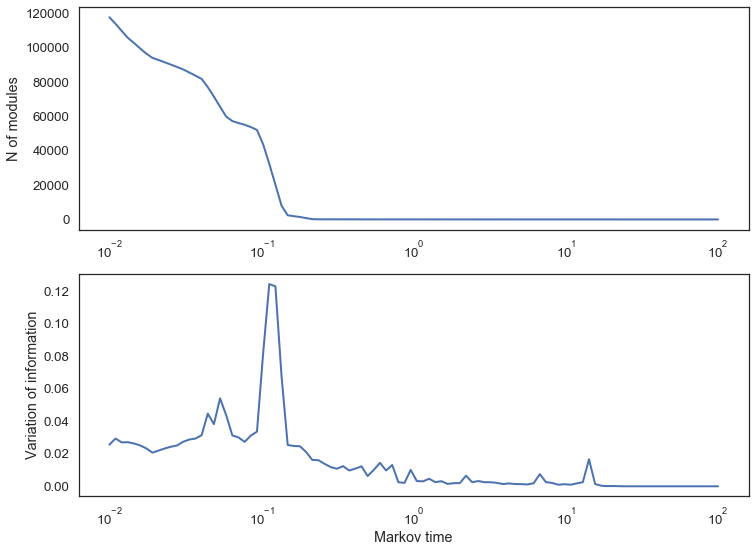

In [75]:
plt.figure(figsize=(12, 9))
# plt.subplot(3, 1, 1)
# plt.plot(time, S)
# plt.ylabel("Stability")
# plt.xscale("log")

plt.subplot(2, 1, 1)
plt.plot(time, N, lw=2)
plt.ylabel("N of modules")
plt.xscale("log")

plt.subplot(2, 1, 2)
plt.plot(time, VI, lw=2)
plt.ylabel("Variation of information")
plt.xscale("log")
plt.xlabel("Markov time")

In [76]:
# for i in range(len(time)):
#     print(i, time[i], VI[i])

time = d_vi[0, 35:90]
S = d_vi[1, 35:90]
N = d_vi[2, 35:90]
VI = d_vi[3, 35:90]

Text(0.5, 0, 'Markov time')

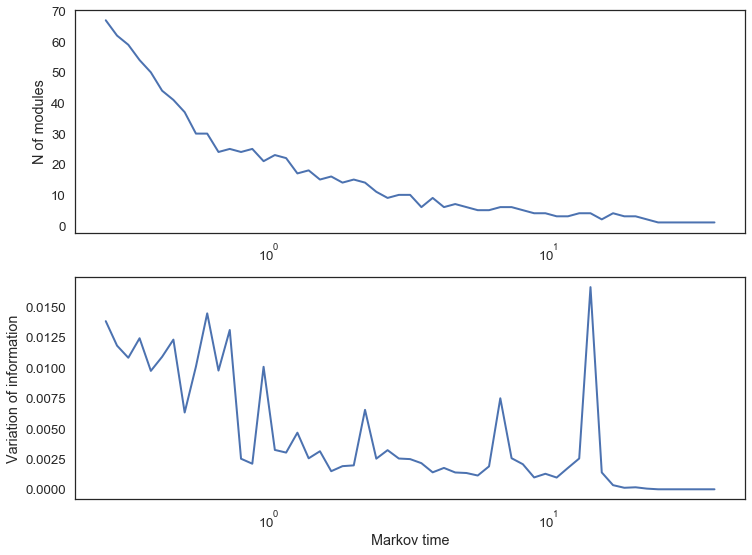

In [77]:
plt.figure(figsize=(12, 9))
# plt.subplot(3, 1, 1)
# plt.plot(time, S)
# plt.ylabel("Stability")
# plt.xscale("log")

plt.subplot(2, 1, 1)
plt.plot(time, N, lw=2)
plt.ylabel("N of modules")
plt.xscale("log")

plt.subplot(2, 1, 2)
plt.plot(time, VI, lw=2)
plt.ylabel("Variation of information")
plt.xscale("log")
plt.xlabel("Markov time")

In [81]:
rst = d_vi[4:, 73]
# rst = d_vi[4:, 48]

new_d = {}
for i, c in enumerate(rst):
    new_d[i+1] = int(c)

In [95]:
# 赋予所属社团

new_dd = {}
for n in G.node():
    G.node[n]["mod"] = new_d[G.node[n]["id"]]
    new_dd[n] = new_d[G.node[n]["id"]]
    
json.dump(new_dd, open("data/louvain_rst_4.json", "w"), indent=2)

In [376]:
comm_nodes = Counter()

for n in G.nodes(data=True):
    c =  n[1]["mod"]
    if n[1]["IRA"] == 1:
        comm_nodes[c] += 1
        
comm_nodes.most_common()

[(1, 233), (0, 134), (3, 95), (2, 35)]

In [377]:
comm_nodes = Counter()

for n in G.nodes(data=True):
    c =  n[1]["mod"]
    comm_nodes[c] += 1
        
comm_nodes.most_common()

[(0, 137953), (1, 31940), (3, 9624), (2, 165)]

In [378]:
# for gephi

plot_these_nodes = []
keep_iras = []

for n in G.node(data=True):
#     if n[1]["mod"] in [7, 1, 11, 3, 2, 8, 6]:
#     if n[1]["mod"] in [1, 8, 14, 4, 0, 11, 3, 13, 7, 2]:
    if n[1]["mod"] in [0, 1, 3]:
        if n[1]["IRA"] == 1:
            keep_iras.append(n[0])
        else:
            plot_these_nodes.append(n[0])
            
len(plot_these_nodes), len(keep_iras)

(179055, 462)

In [379]:
# random sampling for show
import random

plot_these_nodes = random.sample(plot_these_nodes, int(len(plot_these_nodes) * 0.1))
plot_these_nodes.extend(keep_iras)
G = G.subgraph(plot_these_nodes)
G = G.subgraph(max(nx.connected_components(G), key=len))

In [380]:
G = nx.Graph(G)

In [381]:
nx.write_gexf(G, "data/IRA-1-20190701.gexf")

### 划分到不同的网络中

In [68]:
G = nx.read_gpickle("data/ira-interaction.gp")

In [69]:
comm = json.load(open("data/louvain_rst_4.json"))

comm_1 = []
comm_2 = []
comm_3 = []

for uid, c in comm.items():
    if c == 0:
        comm_1.append(uid)
    elif c == 1:
        comm_2.append(uid)
    elif c == 3:
        comm_3.append(uid)
        
len(comm_1), len(comm_2), len(comm_3)

(137953, 31940, 9624)

In [76]:
Gc1 = nx.DiGraph(G.subgraph(comm_1))
nx.write_gpickle(Gc1, "data/graph/C1-one-layer.gpickle")
Gc2 = nx.DiGraph(G.subgraph(comm_2))
nx.write_gpickle(Gc2, "data/graph/C2-one-layer.gpickle")
Gc3 = nx.DiGraph(G.subgraph(comm_3))
nx.write_gpickle(Gc3, "data/graph/C3-one-layer.gpickle")

In [79]:
print(Gc1.number_of_nodes(), Gc1.number_of_edges())
print(Gc2.number_of_nodes(), Gc2.number_of_edges())
print(Gc3.number_of_nodes(), Gc3.number_of_edges())

137953 281455
31940 71150
9624 47832


## The 2nd layer of interaction network

1. 取出每个社团传递的消息（两个节点都需要在某社团中）
2. 定义每个社团的话题和#hashtags
3. 找到更多传播的相关信息（相关话题和hashtags#）
4. 分析每个社团是如何传播消息的

In [2]:
putin = Are_you_IRA()
putin.uncover('19fcd9060d8817ac4a49574b5226e770abff10522d4a7579343e2a99696efa1a')

'19fcd9060d8817ac4a49574b5226e770abff10522d4a7579343e2a99696efa1a'

In [91]:
comm = json.load(open("data/louvain_rst_4.json"))
c = Counter()
for v in comm.values():
    c[v] += 1
c.most_common()

[(0, 137953), (1, 31940), (3, 9624), (2, 165)]

In [81]:
comm = json.load(open("data/louvain_rst_24.json"))
c = Counter()
for v in comm.values():
    c[v] += 1
c.most_common()

[(22, 37882),
 (1, 27958),
 (7, 21373),
 (3, 21316),
 (10, 16738),
 (15, 16499),
 (8, 9838),
 (4, 9092),
 (2, 6696),
 (13, 5874),
 (0, 3491),
 (9, 1515),
 (16, 486),
 (14, 352),
 (12, 294),
 (18, 165),
 (6, 45),
 (11, 20),
 (21, 16),
 (23, 9),
 (17, 7),
 (20, 6),
 (5, 5),
 (19, 5)]

In [ ]:
# ira-ret-links.txt

with open("disk/ira-ret-info.txt", "w") as f:
    for line in tqdm(open("disk/ira-ret-links.txt")):
        w = line.strip().split()
        try:
            if comm[w[1]] == comm[w[2]]:
                f.write(f"{w[0]} {comm[w[1]]}\n")
        except:
            # print(w)
            pass
    head = True
    for line in tqdm(open("disk/ira-ret.txt")):
        if head:
            head = False
            continue
        w = line.strip().split(",")
        try:
            if comm[w[1]] == comm[w[3]]:
                f.write(f"{w[0]} {comm[w[1]]}\n")
        except:
            # print(w)
            pass

In [ ]:
with open("disk/ira-quo-info.txt", "w") as f:
    for line in tqdm(open("disk/ira-quo-links.txt")):
        w = line.strip().split()
        try:
            if comm[w[1]] == comm[w[2]]:
                f.write(f"{w[0]} {comm[w[1]]}\n")
        except:
            # print(w)
            pass
    head = True
    for line in tqdm(open("disk/ira-quo.txt")):
        if head:
            head = False
            continue
        w = line.strip().split(",")
        try:
            if comm[w[1]] == comm[w[3]]:
                f.write(f"{w[0]} {comm[w[1]]}\n")
        except:
            # print(w)
            pass

In [ ]:
with open("disk/ira-rep-info.txt", "w") as f:
    for line in tqdm(open("disk/ira-rep-links.txt")):
        w = line.strip().split()
        try:
            if comm[w[1]] == comm[w[2]]:
                f.write(f"{w[0]} {comm[w[1]]}\n")
        except:
            # print(w)
            pass
    head = True
    for line in tqdm(open("disk/ira-rep.txt")):
        if head:
            head = False
            continue
        w = line.strip().split(",")
        try:
            if comm[w[1]] == comm[w[3]]:
                f.write(f"{w[0]} {comm[w[1]]}\n")
        except:
            # print(w)
            pass

In [ ]:
with open("disk/ira-men-info.txt", "w") as f:
    for line in tqdm(open("disk/ira-men-links.txt")):
        w = line.strip().split()
        try:
            if comm[w[1]] == comm[w[2]]:
                f.write(f"{w[0]} {comm[w[1]]}\n")
        except:
            # print(w)
            pass
    head = True
    for line in tqdm(open("disk/ira-men.txt")):
        if head:
            head = False
            continue
        w = line.strip().split(",")
        try:
            if comm[w[1]] == comm[w[2]]:
                f.write(f"{w[0]} {comm[w[1]]}\n")
        except:
            # print(w)
            pass

In [86]:
with open("disk/ira-int-info.txt", "w") as f:
    [f.write(line) for line in open("disk/ira-ret-info.txt")]
    [f.write(line) for line in open("disk/ira-men-info.txt")]
    [f.write(line) for line in open("disk/ira-rep-info.txt")]
    [f.write(line) for line in open("disk/ira-quo-info.txt")]

In [87]:
from SQLite_handler import find_tweets
from tqdm import tqdm_notebook as tqdm

In [88]:
set_id = set()

for line in open("disk/ira-int-info.txt"):
    tid = line.split()[0]
    if tid in set_id:
        continue
    set_id.add(tid)

In [89]:
set_id = list(set_id)

In [ ]:
tweets_data = find_tweets(set_id)

In [91]:
from pprint import pprint
pprint(tweets_data[0])

{'datetime_EST': '2016-07-07 10:35:25',
 'filename_id': 142,
 'p_pro_hillary_anti_trump': None,
 'place': None,
 'query_id': 0,
 'source_content_id': 2,
 'source_url_id': 2,
 'text': 'RT @jmzxng: Donald Trump is right about Hillary Clinton. \n'
         '\n'
         'Hillary Clinton is right about Donald Trump.\n'
         '\n'
         'Trump agrees w Bernie \n'
         '\n'
         'Clinton ag…',
 'tweet_id': 751077164632698882,
 'user_id': 1868496344}


In [92]:
"没有找到的：", len([t for t in tweets_data if 'error' in t])

('没有找到的：', 232485)

In [93]:
cannot_found = set([str(t["tweet_id"]) for t in tweets_data if 'error' in t])
have_found = set([str(t["tweet_id"]) for t in tweets_data if 'error' not in t])

In [94]:
_d = pd.read_csv("disk/ira_tweets_csv_hashed.csv", usecols=["tweetid", "tweet_text", "userid", "tweet_language", "tweet_time"], dtype=str)

In [95]:
_d = _d[_d.tweet_language=="en"]
_d = _d[_d.tweet_time<"2016-11-09 00:00"]

In [96]:
tweets_data = [t for t in tweets_data if 'error' not in t]

In [97]:
N_bingo = 0
for i, row in tqdm(_d.iterrows()):
    if row.tweetid in cannot_found and row.tweetid not in have_found:
        tweets_data.append({
            "tweet_id": int(row.tweetid),
            "user_id": row.userid,
            "text": row.tweet_text,
            "datetime_EST": row.tweet_time + ":00"
        })
        tweets_data.append(dict(row))
        N_bingo += 1
        
N_bingo

232485

In [104]:
len(tweets_data)

679250

In [105]:
# save edge info

bingo_id = set()

with open("data/link_info_28.json", "w") as f:
    for tweet in tqdm(tweets_data):
        if "tweet_id" not in tweet:
            tweet["tweet_id"] = int(tweet["tweetid"])
        if tweet["tweet_id"] in bingo_id:
            continue
        bingo_id.add(tweet["tweet_id"])
        f.write(json.dumps(tweet) + "\n")

In [106]:
tweets_data = [t for t in tweets_data if 'error' not in t]

In [107]:
tweets_data[-1]

{'tweetid': '773536131208122368',
 'userid': '2882013788',
 'tweet_language': 'en',
 'tweet_text': "RT @TiMiR0: #IfICouldntLie I couldn't tell you all dogs go to heaven. https://t.co/t7lDUA03Ll",
 'tweet_time': '2016-09-07 14:59',
 'tweet_id': 773536131208122368}

## 针对社团中的消息进行话题分类及分布

(0, '0.016*"people" + 0.010*"white" + 0.009*"see" + 0.009*"@realdonaldtrump" + 0.008*"need" + 0.008*"think" + 0.007*"@danageezus" + 0.007*"work" + 0.006*"game" + 0.006*"house"'), 

(1, '0.040*"#new" + 0.020*"#world" + 0.008*"death" + 0.007*"#foke" + 0.007*"foke" + 0.006*"force" + 0.006*"#myolympicsportwouldbe" + 0.006*"kill" + 0.006*"#rejecteddebatetopic" + 0.005*"top"'), 

(2, '0.012*"kill" + 0.010*"cop" + 0.009*"old" + 0.009*"black" + 0.009*"@midnight" + 0.008*"people" + 0.008*"@gloed_up" + 0.007*"#blacklivesmatter" + 0.006*"play" + 0.006*"gun"'), 

(3, '0.013*"#sport" + 0.008*"#topnew" + 0.007*"#politic" + 0.006*"attack" + 0.006*"#tech" + 0.006*"high" + 0.006*"win" + 0.006*"post" + 0.006*"😂" + 0.005*"#obamaswishlist"'),

(4, '0.009*"@giselleevns" + 0.007*"️" + 0.007*"name" + 0.006*"@chrixmorgan" + 0.006*"send" + 0.006*"#betteralternativetodebate" + 0.006*"become" + 0.006*"child" + 0.006*"nothing" + 0.006*"music"'), 

(5, '0.041*"trump" + 0.026*"hillary" + 0.022*"clinton" + 0.012*"vote" + 0.008*"donald" + 0.008*"great" + 0.007*"american" + 0.006*"never" + 0.006*"campaign" + 0.006*"america"'), 

(6, '0.025*"man" + 0.020*"police" + 0.014*"woman" + 0.013*"black" + 0.010*"shoot" + 0.009*"life" + 0.009*"live" + 0.007*"right" + 0.007*"try" + 0.007*"year"')

In [108]:
# import importlib
# importlib.reload(my_topic.KTopic)
from my_topic import KTopic

In [109]:
Lebron = KTopic()
Lebron.load_model()
Lebron.load_text()

你若相信，它便存在。
Loading ...


In [14]:
# load

topic_rsts = {}

# for line in open("data/link_topic_28.json"):
#     d = json.loads(line.strip())
#     topic_rsts[d["tweet_id"]] = np.array(d["topic"])
    
for line in open("data/link_topic.json"):
    d = json.loads(line.strip())
    topic_rsts[d["tweet_id"]] = np.array(d["topic"])

In [15]:
tid_comm = {}

for line in open("disk/ira-int-info.txt"):
    tid, c = line.split()
    if tid in tid_comm:
        continue
    tid_comm[int(tid)] = int(c)

In [ ]:
comm_topic = {}

for tid, c in tid_comm.items():
    if c not in comm_topic:
        comm_topic[c] = np.zeros(7)
    comm_topic[c] += topic_rsts[tid]

### 三个社团的话题分布

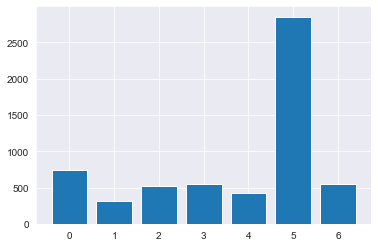

In [10]:
plt.bar(range(7), comm_topic[0])
plt.xticks(range(7))
pass

<BarContainer object of 7 artists>

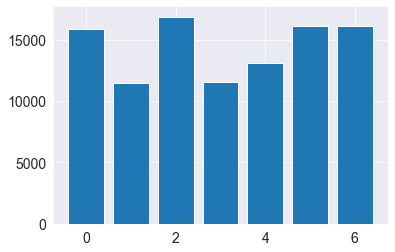

In [79]:
plt.bar(range(7), comm_topic[1])

<BarContainer object of 7 artists>

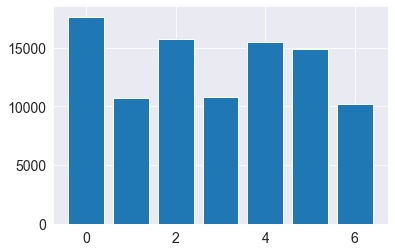

In [80]:
plt.bar(range(7), comm_topic[4])

### 28个社团的话题分布

[(22, 37882),
 (1, 27958),
 (7, 21373),
 (3, 21316),
 (10, 16738),
 (15, 16499),
 (8, 9838),
 (4, 9092),
 (2, 6696),
 (13, 5874),
 (0, 3491),

In [ ]:
plt.bar(range(7), comm_topic[22])
plt.xticks(range(7))

----------

# 找到hashtags相关的第二层!!!

考虑方向

In [3]:
!head disk/second_layer.txt

{"#":["tcot","pjnet"],"userid":703971353351696384,"id":"737848323919335424","n1":"1339835893","n2":"703971353351696384"}
{"#":["maga"],"userid":733828747690811392,"id":"737848331863359488","n1":"759251","n2":"733828747690811392"}
{"#":["imwithher"],"userid":810145062,"id":"737848380832026628","n1":"1339835893","n2":"810145062"}
{"#":["benghazi"],"userid":88071033,"id":"737848406958321666","n1":"2188423838","n2":"88071033"}
{"#":["trump","maga"],"userid":901903482,"id":"737848410779197440","n1":"708560981060784128","n2":"901903482"}
{"#":["neverhillary","trump2016"],"userid":4499094387,"id":"737848433088815104","n1":"620571475","n2":"4499094387"}
{"#":["trump"],"userid":4550874792,"id":"737848434904829953","n1":"1917731","n2":"4550874792"}
{"#":["hillary"],"userid":26957062,"id":"737848457805758464","n1":"4761064634","n2":"26957062"}
{"#":["neverhillary","hillary"],"userid":804041095,"id":"737848470627885056","n1":"2316246829","n2":"804041095"}
{"#":["feelthebern"],"userid":1247798108,"

In [466]:
G = nx.read_gpickle("data/ira-interaction.gp")
G.number_of_nodes(), G.number_of_edges()

(179783, 432429)

In [46]:
# _edges = set()
G = nx.DiGraph(G)

for line in tqdm(open("disk/second_layer.txt")):
    d = json.loads(line.strip())
    n1 = d["n1"]
    n2 = d["n2"]
    if n1 == n2:
        continue
    elif n1 in G.node or n2 in G.node:
        G.add_edge(n1, n2)
        
G.number_of_nodes(), G.number_of_edges(), G.number_of_edges() / G.number_of_nodes()

(380601, 7597394, 19.961571304331834)

In [8]:
G = max(nx.weakly_connected_component_subgraphs(G), key=len)
G.number_of_nodes(), G.number_of_edges(), G.number_of_edges() / G.number_of_nodes()

(380561, 7597368, 19.963601104684926)

In [9]:
putin = Are_you_IRA()

for i, n in enumerate(G.nodes()):
    if putin.fuck(n):
        G.node[n]["IRA"] = 1
    else:
        G.node[n]["IRA"] = 0

In [10]:
nx.write_gpickle(G, "data/IRA-two-layers.gpickle")

In [3]:
G = nx.read_gpickle("data/IRA-two-layers.gpickle")

In [6]:
save_for_matlab(G, "data/ira-int-2-undir.net")
G.number_of_nodes(), G.number_of_edges()

change into undir and get the connected component
380561 7559868


(380561, 7597368)

In [479]:
# for gephi

plot_these_nodes = []
keep_iras = []

for n in G.node():
    if Putin.fuck(n) or G.degree(n) > 30000:
        keep_iras.append(n)
    else:
        plot_these_nodes.append(n)
            
len(plot_these_nodes), len(keep_iras)

(418758, 517)

In [480]:
# random sampling for show
import random

plot_these_nodes = random.sample(plot_these_nodes, int(len(plot_these_nodes) * 0.01))
plot_these_nodes.extend(keep_iras)
sampleG = G.subgraph(plot_these_nodes)
sampleG = sampleG.subgraph(max(nx.weakly_connected_components(sampleG), key=len))
# G = G.subgraph(max(nx.connected_components(G), key=len))
nx.write_gexf(sampleG, "data/IRA-2.gexf")

In [19]:
from build_network import nx2gt

In [20]:
for n in G.nodes():
    try:
        del G.node[n]["IRA"]
    except:
        pass
    try:
        del G.node[n]["id"]
    except:
        pass

In [21]:
gt = nx2gt(G)

converting ...


In [22]:
gt

<Graph object, directed, with 380561 vertices and 7597368 edges at 0x7f4aaecebe80>

In [23]:
gt.save("data/IRA_two_layers.gt")

In [44]:
G.number_of_nodes(), G.number_of_selfloops()

380561

In [382]:
G = gt.load("data/IRA_two_layers.gt")

In [485]:
# G = nx.read_gpickle("data/IRA-two-layers.gpickle")
G = nx.read_gpickle("data/ira-interaction.gp")

In [12]:
G.degree("25073877"), G.out_degree("25073877"), G.in_degree("25073877")

(99145, 99113, 32)

In [13]:
G.degree("1339835893"), G.out_degree("1339835893"), G.in_degree("1339835893")

(90289, 90257, 32)

# 找到hashtags相关的第二层!!（不同社团）

In [481]:
!head disk/second_layer_C1.txt

{"#":["hannity"],"userid":2248442846,"id":"737848312003366913","n1":"25073877","n2":"2248442846"}
{"#":["tcot","pjnet"],"userid":703971353351696384,"id":"737848323919335424","n1":"1339835893","n2":"703971353351696384"}
{"#":["maga"],"userid":733828747690811392,"id":"737848331863359488","n1":"759251","n2":"733828747690811392"}
{"#":["imwithher"],"userid":810145062,"id":"737848380832026628","n1":"1339835893","n2":"810145062"}
{"#":["hannity"],"userid":713895213337559041,"id":"737848382467756033","n1":"25073877","n2":"713895213337559041"}
{"#":["benghazi"],"userid":88071033,"id":"737848406958321666","n1":"2188423838","n2":"88071033"}
{"#":["trump","maga"],"userid":901903482,"id":"737848410779197440","n1":"708560981060784128","n2":"901903482"}
{"#":["neverhillary","trump2016"],"userid":4499094387,"id":"737848433088815104","n1":"620571475","n2":"4499094387"}
{"#":["trump"],"userid":4550874792,"id":"737848434904829953","n1":"1917731","n2":"4550874792"}
{"#":["hillary"],"userid":26957062,"id"

In [482]:
G = nx.read_gpickle("data/ira-interaction.gp")
G.number_of_nodes(), G.number_of_edges()

(179783, 432429)

In [485]:
louvain_rst = json.load(open("data/louvain_rst_4.json"))
from collections import defaultdict

Putin = Are_you_IRA()

comm_nodes = defaultdict(set)

for n, c in louvain_rst.items():
#     if not Putin.check(n):
#         continue
    if c == 0:
        c = 1
    elif c == 1:
        c = 2
    elif c == 3:
        c = 3
    else:
        continue
    comm_nodes[c].add(n)

In [486]:
for cN, userids in comm_nodes.items():
    print("#C", cN)
    _sub_G = G.subgraph(userids)
    _sub_G = nx.DiGraph(_sub_G)
    
    for line in tqdm(open(f"disk/second_layer_C{cN}.txt")):
        d = json.loads(line.strip())
        n1 = d["n1"]
        n2 = d["n2"]
        if n1 == n2:
            continue
        elif n1 in _sub_G.node or n2 in _sub_G.node:
            _sub_G.add_edge(n1, n2)
    
    nx.write_gpickle(_sub_G, f"data/graph/C{cN}-two-layer.gpickle")
    print(_sub_G.number_of_nodes(), _sub_G.number_of_edges(), _sub_G.number_of_edges() / _sub_G.number_of_nodes())

#C 1



316046 7406348 23.43439879004955
#C 3



24914 90784 3.6438949987958575
#C 2



100741 410963 4.079401633892854


In [7]:
import random

# for gephi
for cN in range(1, 4):
    plot_these_nodes = []
    keep_iras = []

    G = nx.read_gpickle(f"data/graph/C{cN}-two-layer.gpickle")
    
    for n in G.node():
        if Putin.check(n) or G.degree(n) > 50000:
            keep_iras.append(n)
        else:
            plot_these_nodes.append(n)

    print(len(plot_these_nodes), len(keep_iras))

    plot_these_nodes = random.sample(plot_these_nodes, int(len(plot_these_nodes) * 0.01))
    plot_these_nodes.extend(keep_iras)
    sampleG = G.subgraph(plot_these_nodes)
    sampleG = sampleG.subgraph(max(nx.weakly_connected_components(sampleG), key=len))
    # G = G.subgraph(max(nx.connected_components(G), key=len))
    for n in G.nodes():
        if Putin.check(n):
            G.node[n]["IRA"] = 1
        else:
            G.node[n]["IRA"] = 0
    nx.write_gexf(sampleG, f"data/graph/C{cN}-two-layer.gexf")

315878 168
100478 263
24802 112


## Analyzing two-layer network

分析IRA两层网络

In [43]:
G = nx.read_gpickle("data/IRA-two-layers.gpickle")

In [29]:
from fake_identify import Are_you_IRA

putin = Are_you_IRA()

def get_G_char(g_file):
    print(g_file, "...")
    G = nx.read_gpickle(g_file)
    
    n_nodes = G.number_of_nodes()
    n_edges = G.number_of_edges()
    k = G.number_of_edges() / G.number_of_nodes()

    out_d = pd.Series([k[1] for k in G.out_degree()])
    # print(out_d)
    ave_out_d = out_d.mean()
    std_out_d = out_d.std() / k
    max_out_d = out_d.max()

    in_d = pd.Series([k[1] for k in G.in_degree()])
    # print(in_d)
    ave_in_d = in_d.mean()
    std_in_d = in_d.std() / k
    max_in_d = in_d.max()

    return {
        "N nodes": int(n_nodes),
        "N edges": int(n_edges),
        "<k>": k,
        "std(k_out) / <k>": std_out_d,
        "std(k_in) / <k>": std_in_d,
        "max(k_out)": int(max_out_d),
        "max(k_in)": int(max_in_d),
    }        


def get_G_char_IRA(g_file):
    print(g_file, "...")
    G = nx.read_gpickle(g_file)
    nodes = [n for n in G.node() if Putin.fuck(n)]
    n_nodes = len(nodes)
            
    out_d = pd.Series([G.out_degree(n) for n in nodes])
    ave_k_out = out_d.sum() / n_nodes
    std_k_out = out_d.std() / ave_k_out
    max_out_d = out_d.max()

    in_d = pd.Series([G.in_degree(n) for n in nodes])
    ave_k_in = in_d.sum() / n_nodes
    std_k_in = in_d.std() / ave_k_in
    max_in_d = in_d.max()
    
    return {
        "N nodes": int(n_nodes),
        "<k_out>": ave_k_out,
        "<k_in>": ave_k_in,
        "std(k_out) / <k_out>": std_k_out,
        "std(k_in) / <k_in>": std_k_in,
        # "N cover": len(cover_set),
        "max(k_out)": int(max_out_d),
        "max(k_in)": int(max_in_d),
    }


In [40]:
networks_char1 = get_G_char("data/IRA-two-layers.gpickle")

data/IRA-two-layers.gpickle ...


In [47]:
networks_char = {}
networks_char["Whole"] = networks_char1
networks_char = pd.DataFrame(networks_char).transpose().round(1)
networks_char = networks_char[["N nodes", "N edges", "<k>", "std(k_out) / <k>", "std(k_in) / <k>", "max(k_out)", "max(k_in)"]]
networks_char = networks_char.astype({
    "N nodes": int,
    "N edges": int,
    "max(k_out)": int,
    "max(k_in)": int,
})

networks_char.to_csv("data/two_layers_network.csv", float_format="%.1f")
networks_char

,N nodes,N edges,<k>,std(k_out) / <k>,std(k_in) / <k>,max(k_out),max(k_in)
Whole,380561,7597368,20.0,22.8,3.4,99113,8470


In [48]:
networks_char2 = get_G_char_IRA("data/IRA-two-layers.gpickle")

data/IRA-two-layers.gpickle ...


In [51]:
networks_char = {}
networks_char["IRA"] = networks_char2

networks_char = pd.DataFrame(networks_char).round(1).transpose()
networks_char = networks_char[["N nodes", "<k_out>", "<k_in>", "std(k_out) / <k_out>", "std(k_in) / <k_in>", "max(k_out)", "max(k_in)"]]
networks_char = networks_char.astype({
    "N nodes": int,
    "max(k_out)": int,
    "max(k_in)": int,
})

networks_char.to_csv("data/two_layers_network_IRA.csv", float_format="%.1f")
networks_char

,N nodes,<k_out>,<k_in>,std(k_out) / <k_out>,std(k_in) / <k_in>,max(k_out),max(k_in)
IRA,510,500.2,353.2,8.9,1.8,82012,8470


# Time Series Analysis of two-laryer network

In [542]:
G = nx.read_gpickle("data/IRA-two-layers.gpickle")

In [121]:
# save node

with open("data/two-layers-non-IRA.txt", "w") as f:
    for n in G.nodes():
        if G.node[n]["IRA"] == 0:
            f.write(n + "\n")
            
with open("data/two-layers-IRA.txt", "w") as f:
    for n in G.nodes():
        if G.node[n]["IRA"] == 1:
            f.write(n + "\n")

In [122]:
# read nodes
IRA_nodes = set([line.strip() for line in open("data/two-layers-IRA.txt")])
len(IRA_nodes)

524

In [394]:
IRA_data = pd.read_csv("data/ira-tweets-ele.csv")

In [395]:
IRA_data.columns

Index(['tweetid', 'userid', 'user_display_name', 'user_screen_name',
       'user_reported_location', 'user_profile_description',
       'user_profile_url', 'follower_count', 'following_count',
       'account_creation_date', 'account_language', 'tweet_language',
       'tweet_text', 'tweet_time', 'tweet_client_name', 'in_reply_to_tweetid',
       'in_reply_to_userid', 'quoted_tweet_tweetid', 'is_retweet',
       'retweet_userid', 'retweet_tweetid', 'latitude', 'longitude',
       'quote_count', 'reply_count', 'like_count', 'retweet_count', 'hashtags',
       'urls', 'user_mentions', 'poll_choices'],
      dtype='object')

In [396]:
len(IRA_data.userid.unique())

556

In [20]:
dts = []

for i, row in tqdm(IRA_data.iterrows()):
    u = Putin.uncover(row.userid)
    if u in IRA_nodes:
        dts.append(row.tweet_time)

In [21]:
ts = pd.to_datetime(dts)
ts = ts.value_counts()
ts = ts.resample("15Min").sum()
ts = ts[(ts.index >= "2016-06-01") & (ts.index < "2016-11-09")]

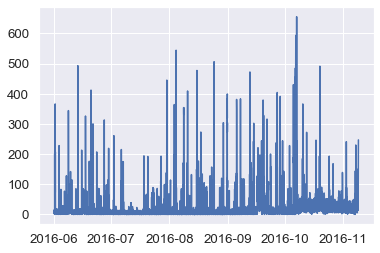

In [23]:
plt.plot(ts)

In [149]:
# read nodes
non_IRA_nodes = set([line.strip() for line in open("data/two-layers-non-IRA.txt")])
len(non_IRA_nodes)

179259

In [150]:
# from pathlib import Path

non_dts = []
for line in tqdm(open('disk/user_time.txt')):
    w = line.strip().split()
    uid = w[1]
    _dt = w[2] + " " + w[3]
    if uid in non_IRA_nodes:
        non_dts.append(_dt)

In [ ]:
import pendulum
# from datetime import datetime
from datetime import timedelta

# non_ts = pd.to_datetime(non_dts)
non_ts = [pendulum.parse(_d) for _d in tqdm(non_dts)]
# non_ts = [pendulum.parse(_d).add(hours=-4) for _d in tqdm(non_dts)]

# 4:00 转化为 0:00 统计天最少的

In [152]:
non_ts = pd.to_datetime(non_dts)
non_ts = non_ts.value_counts()

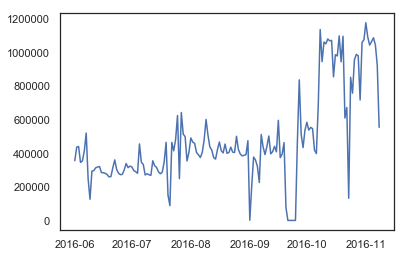

In [164]:
_non_1D = non_ts.resample("1D").sum()
_non_1D = _non_1D[(_non_1D.index >= "2016-06-01") & (_non_1D.index < "2016-11-09")]
plt.plot(_non_1D)

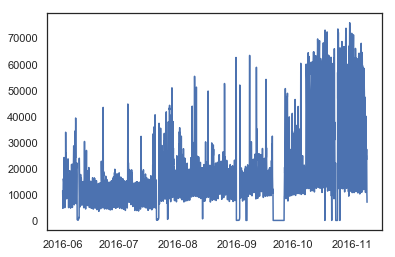

In [159]:
# _non_ts = non_ts.resample("15Min").sum()
_non_ts = non_ts.resample("1H").sum()
_non_ts = _non_ts[(_non_ts.index >= "2016-06-01") & (_non_ts.index < "2016-11-09")]
plt.plot(_non_ts)

### 需要去掉活跃度非常低的时间片段（days）

In [168]:
# _non_ts = non_ts.resample("1D").sum()
should_remove = _non_1D[_non_1D < 300000] # 当天少于36万数据量的不要
len(should_remove)

36

In [170]:
should_remove = _non_ts[_non_ts < 2000] # 当天少于36万数据量的不要
len(should_remove)

295

In [ ]:
should_remove

In [105]:
should_remove = should_remove.index

In [106]:
from datetime import timedelta

should_remove = [should_remove + timedelta(hours=4)]

In [107]:
with open("data/should_be_removed_in_timeseries.txt", "w") as f:
    for _ss in should_remove[0]:
        print(_ss)
        f.write(str(_ss) + "\n")

2016-06-09 04:00:00
2016-07-20 04:00:00
2016-07-21 04:00:00
2016-09-01 04:00:00
2016-09-02 04:00:00
2016-09-06 04:00:00
2016-09-20 04:00:00
2016-09-21 04:00:00
2016-09-22 04:00:00
2016-09-23 04:00:00
2016-09-24 04:00:00
2016-09-25 04:00:00
2016-10-23 04:00:00


In [181]:
import pendulum
from datetime import datetime

def load_should_remove():
    # should_remove = set()
    
    for line in open("data/should_be_removed_in_timeseries.txt"):
        _dt = line.strip()
        _start = datetime.strptime(_dt, '%Y-%m-%d %H:%M:%S')
        for _dt in pd.date_range(start=_start, periods=4 * 24, freq="15Min"):
            should_remove_15Min.append(pd.to_datetime(_dt))

    return should_remove_15Min

In [ ]:
non_ts = non_ts[~non_ts.index.isin(should_remove_15Min)]
ts = ts[~ts.index.isin(should_remove_15Min)]

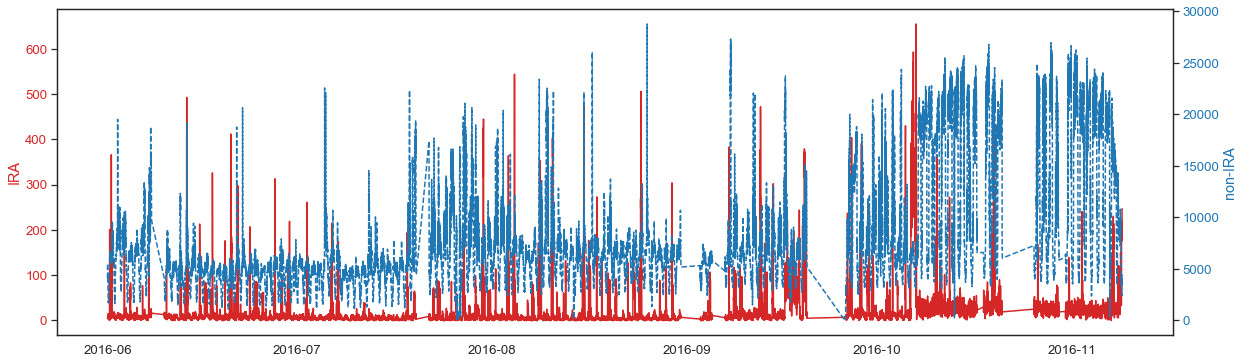

In [25]:
sns.set(style="white", font_scale=1.2)
fig, ax1 = plt.subplots(figsize=(20, 6))
color = 'tab:red'
ax1.set_ylabel('IRA', color=color)  # we already handled the x-label with ax1
ax1.plot(ts, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('non-IRA', color=color)  # we already handled the x-label with ax1
ax2.plot(non_ts, "--", color=color)
ax2.tick_params(axis='y', labelcolor=color)

In [63]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(ts, freq=4)
non_result = seasonal_decompose(non_ts, freq=4)

# print(non_result.trend)
# print(non_result.seasonal)
# print(non_result.resid)
# print(non_result.observed)

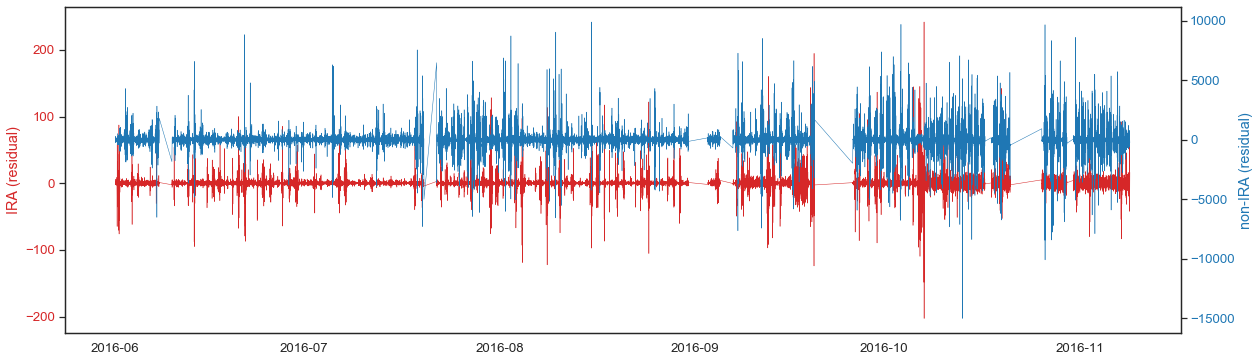

In [64]:
sns.set(style="white", font_scale=1.2)
fig, ax1 = plt.subplots(figsize=(20, 6))
color = 'tab:red'
ax1.set_ylabel('IRA (residual)', color=color)  # we already handled the x-label with ax1
# ax1.set_ylim((-600, 600))
ax1.plot(result.resid, color=color, lw=0.5)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('non-IRA (residual)', color=color)  # we already handled the x-label with ax1
# ax2.set_ylim((-20000, 20000))
ax2.plot(non_result.resid, color=color, lw=0.5)
ax2.tick_params(axis='y', labelcolor=color)

In [ ]:
from statsmodels.tsa.stattools import grangercausalitytests

IRA_resid = result.resid.dropna(); non_resid = non_result.resid.dropna()
for_gra = np.array([non_resid, IRA_resid]).T
print(for_gra)
# np.savetxt("test.txt", for_gra)
grangercausalitytests(for_gra, maxlag=4 * 8)

print('- '* 60)
for_gra = np.array([IRA_resid, non_resid]).T
print(for_gra)
# np.savetxt("test.txt", for_gra)
grangercausalitytests(for_gra, maxlag=4 * 8)

# second-layer 时间序列因果分析 

## Three communities > spreading > timeseries analysis

In [59]:
louvain_rst = json.load(open("data/louvain_rst_4.json"))

In [60]:
from collections import defaultdict

comm_nodes = defaultdict(set)

for n, c in louvain_rst.items():
    if c == 0:
        c = 1
    elif c == 1:
        c = 2
    elif c == 3:
        c = 3
    else:
        continue
    comm_nodes[c].add(n)

len(comm_nodes[1]), len(comm_nodes[2]), len(comm_nodes[3])

(137953, 31940, 9624)

In [460]:
G2 = nx.read_gpickle("data/IRA-two-layers.gpickle")

In [138]:
import copy

# --------------- very important ---------------
# 社团扩展第二层，但是扩展的时候用到的是同样一批hashtag

for i in range(4):
    first_layer_nodes = copy.deepcopy(comm_nodes[i])
    for n in comm_nodes[i]:
#         print(n)
        for nj in G2.successors(n):
            first_layer_nodes.add(nj)
        for nj in G2.predecessors(n):
            first_layer_nodes.add(nj)
#     print(len(first_layer_nodes))
    G2_c = nx.DiGraph(G2.subgraph(first_layer_nodes))
    print(G2_c.number_of_nodes(), G2_c.number_of_edges())
    nx.write_gpickle(G2_c, f"data/louvain_2_layers/{i}.gpickle")

321207 7486362
209551 7199455
1220 13774
100112 6248694


In [243]:
from pathlib import Path
import importlib
import build_network
importlib.reload(build_network)

# for graph-tool to calculate CI

for in_name in Path().rglob("data/graph/C*"):
    _G = nx.read_gpickle(in_name)
    _G = build_network.nx2gt(_G)
    _G.save(in_name.name[:-8] + ".gt")

converting ...
converting ...
converting ...
converting ...


In [131]:
G_c0 = nx.read_gpickle("data/louvain_2_layers/0.gpickle")

## 扩展！用不同的hashtags

In [ ]:
from pathlib import Path
import importlib
import build_network
importlib.reload(build_network)

# for graph-tool to calculate CI

for in_name in Path().rglob("data/graph/C*"):
    _G = nx.read_gpickle(in_name)
    _G = build_network.nx2gt(_G)
    _G.save(in_name.name[:-8] + ".gt")

In [10]:
import pendulum
from datetime import datetime

def load_should_remove():
    should_remove_15Min = []
    
    for line in open("data/should_be_removed_in_timeseries.txt"):
        _dt = line.strip()
        _start = datetime.strptime(_dt, '%Y-%m-%d %H:%M:%S')
        for _dt in pd.date_range(start=_start, periods=4 * 24, freq="15Min"):
            should_remove_15Min.append(pd.to_datetime(_dt))

    return should_remove_15Min

should_remove_15Min = load_should_remove()
user_support = json.load(open("disk/user_hillary_trump.json"))
users_opinion = {}
opinion = Counter()

for uid, v in tqdm(user_support.items()):
    if v[0] > v[1]:
        users_opinion[uid] = "C"
        opinion["C"] += 1
    elif v[0] < v[1]:
        users_opinion[uid] = "T"
        opinion["T"] += 1
    else:
        users_opinion[uid] = "U"
        opinion["U"] += 1
        

In [36]:
def get_tsss(cN, layer="one"):
    def get_ts(IRA_nodes):
        dts = []
        for i, row in tqdm(IRA_data.iterrows()):
            u = Putin.uncover(row.userid)
            if u in IRA_nodes:
                _dt = row.tweet_time
                _dt = pendulum.parse(_dt).add(hours=-4).to_datetime_string()
                dts.append(_dt)
        ts = pd.to_datetime(dts)
        ts = ts.value_counts()
        ts = ts.resample("15Min").sum()
        ts = ts[(ts.index >= "2016-06-01") & (ts.index < "2016-11-09")]
        ts = ts[~ts.index.isin(should_remove_15Min)]
        return ts
    
    def get_non(non_IRA_nodes):
        non_dts = []
        for line in tqdm(open('disk/user_time.txt')):
            w = line.strip().split()
            uid = w[1]
            _dt = w[2] + " " + w[3]
            if uid in non_IRA_nodes:
                non_dts.append(_dt)

        non_ts = pd.to_datetime(non_dts)
        non_ts = non_ts.value_counts()
        non_ts = non_ts.resample("15Min").sum()
        non_ts = non_ts[(non_ts.index >= "2016-06-01") & (non_ts.index < "2016-11-09")]
        non_ts = non_ts[~non_ts.index.isin(should_remove_15Min)]
        return non_ts

    G = nx.read_gpickle(f"data/graph/C{cN}-{layer}-layer.gpickle")
    IRA_nodes = set([n for n in G.nodes if Putin.check(n)])
    non_IRA_nodes = set([n for n in G.nodes if not Putin.check(n)])
    T_IRA_nodes = set([n for n in G.nodes if not Putin.check(n) and n in users_opinion and users_opinion[n] == "T"])
    C_IRA_nodes = set([n for n in G.nodes if not Putin.check(n) and n in users_opinion and users_opinion[n] == "C"])
    
    ts = get_ts(IRA_nodes)
    non_ts = get_non(non_IRA_nodes)
    T_ts = get_non(T_IRA_nodes)
    C_ts = get_non(C_IRA_nodes)

    tsts = pd.DataFrame({"ts": ts, "non_ts": non_ts, "T_ts": T_ts, "C_ts": C_ts})
    tsts.to_pickle(f"data/tsts/C{cN}-{layer}-layer.pickle")

In [37]:
# 获取需要分析的时间序列
get_tsss(1)
get_tsss(2)
get_tsss(3)
# get_tsss(1, "two")
# get_tsss(2, "two")
# get_tsss(3, "two")

In [73]:
def get_15min(dt):
    _dt = pendulum.parse(dt)
    t0 = pendulum.parse(_dt.format("YYYY-MM-DD HH:00:00"))
    t1 = t0.add(minutes=15)
    t2 = t0.add(minutes=30)
    t3 = t0.add(minutes=45)

    if t0 <= _dt < t1:
        return t0
    elif _dt < t2:
        return t1
    elif _dt < t3:
        return t2
    else:
        return t3


def get_tsss_user(cN, layer="one"):
    def get_ts(IRA_nodes):
        user_set = set()
        dts = []
        for i, row in tqdm(IRA_data.iterrows()):
            u = Putin.uncover(row.userid)
            if u in IRA_nodes:
                _dt = row.tweet_time
                _dt = pendulum.parse(_dt).add(hours=-4).to_datetime_string()
                _dt = get_15min(_dt).to_datetime_string()
                if u + "~" + _dt not in user_set:
                    user_set.add(u + "~" + _dt)
                    dts.append(_dt)
                    
        ts = pd.to_datetime(dts)
        ts = ts.value_counts()
        ts = ts.resample("15Min").sum()
        ts = ts[(ts.index >= "2016-06-01") & (ts.index < "2016-11-09")]
        ts = ts[~ts.index.isin(should_remove_15Min)]
        return ts
    
    def get_non(non_IRA_nodes):
        user_set = set()
        non_dts = []
        for line in tqdm(open('disk/user_time_15Mins.txt')):
            w = line.strip().split()
            u = w[1]
            _dt = w[2] + " " + w[3]
            if uid in non_IRA_nodes:
                if u + "~" + _dt not in user_set:
                    user_set.add(u + "~" + _dt)
                    non_dts.append(_dt)
                    
        non_ts = pd.to_datetime(non_dts)
        non_ts = non_ts.value_counts()
        non_ts = non_ts.resample("15Min").sum()
        non_ts = non_ts[(non_ts.index >= "2016-06-01") & (non_ts.index < "2016-11-09")]
        non_ts = non_ts[~non_ts.index.isin(should_remove_15Min)]
        return non_ts

    G = nx.read_gpickle(f"data/graph/C{cN}-{layer}-layer.gpickle")
    IRA_nodes = set([n for n in G.nodes if Putin.check(n)])
    non_IRA_nodes = set([n for n in G.nodes if not Putin.check(n)])
    T_IRA_nodes = set([n for n in G.nodes if not Putin.check(n) and n in users_opinion and users_opinion[n] == "T"])
    C_IRA_nodes = set([n for n in G.nodes if not Putin.check(n) and n in users_opinion and users_opinion[n] == "C"])
    
    ts = get_ts(IRA_nodes)
    non_ts = get_non(non_IRA_nodes)
    T_ts = get_non(T_IRA_nodes)
    C_ts = get_non(C_IRA_nodes)

    tsts = pd.DataFrame({"ts": ts, "non_ts": non_ts, "T_ts": T_ts, "C_ts": C_ts})
    tsts.to_pickle(f"data/tsts/C{cN}-{layer}-layer-user.pickle")

In [74]:
# 获取需要分析的时间序列
get_tsss_user(1)
get_tsss_user(2)
get_tsss_user(3)
get_tsss_user(1, "two")
get_tsss_user(2, "two")
get_tsss_user(3, "two")

In [13]:
tsts = pd.read_pickle(f"data/tsts/C1-two-layer.pickle")

In [16]:
pd.options.display.max_rows = 1000
tsts[tsts.non_ts <= 100]

,ts,non_ts,T_ts,C_ts
2016-10-30 07:15:00,2.0,0,0,0
2016-10-30 07:30:00,5.0,0,0,0


In [123]:
# from stldecompose import decompose, forecast
import matplotlib.ticker as ticker


def format_date(x, pos=None):
    #保证下标不越界,很重要,越界会导致最终plot坐标轴label无显示
    # thisind = np.clip(int(x+0.5), 0, N-1)
    print(type(x), x)
    return x.strftime('%Y-%m-%d')
    
    
def analyze_ts_of_communities(cN, layer="one", user=False):
    if user:
        tsts = pd.read_pickle(f"data/tsts/C{cN}-{layer}-layer-user.pickle")
    else:
        tsts = pd.read_pickle(f"data/tsts/C{cN}-{layer}-layer.pickle")
    # print(tsts)
    sns.set(style="white", font_scale=1.2)
    fig, ax1 = plt.subplots(figsize=(20, 6))
    color = 'tab:red'
    ax1.set_ylabel('IRA', color=color)  # we already handled the x-label with ax1
    ax1.plot("ts", data=tsts, color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    color = 'tab:blue'
    ax2.set_ylabel('non-IRA', color=color)  # we already handled the x-label with ax1
    ax2.plot("non_ts", data=tsts, color=color, lw=0.8)
    ax2.tick_params(axis='y', labelcolor=color)
    
    # ax2.xaxis.set_major_formatter(ticker.FuncFormatter(format_date))
    # fig.autofmt_xdate()
    
    plt.savefig(f"fig/c{cN}-{layer}-layer-ts.pdf", dpi=300)
    plt.show()
    plt.close()
    
    if user:
        tsts_resid = pd.read_pickle(f"data/tsts/resid_C{cN}-{layer}-layer-user.pl")
    else:
        tsts_resid = pd.read_pickle(f"data/tsts/resid_C{cN}-{layer}-layer.pl")
        
    # print(tsts_resid)
    sns.set(style="white", font_scale=1.2)
    fig, ax1 = plt.subplots(figsize=(20, 6))
    color = 'tab:red'
    ax1.set_ylabel('IRA (residuals)', color=color)  # we already handled the x-label with ax1
    # ax1.set_ylim((-600, 600))
    ax1.plot("ts", data=tsts_resid, color=color, lw=1)
    ax1.tick_params(axis='y', labelcolor=color)
    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    color = 'tab:blue'
    ax2.set_ylabel("non-IRA (residuals)", color=color)  # we already handled the x-label with ax1
    # ax2.set_ylim((-20000, 20000))
    ax2.plot("non_ts", data=tsts_resid, color=color, lw=1)
    ax2.tick_params(axis='y', labelcolor=color)
    plt.savefig(f"fig/c{cN}-{layer}-layer-resid.pdf", dpi=300)
    plt.show()
    plt.close()
    
    sns.set(style="white")
    # 相关性分析
#     f = plt.figure(figsize=(7, 6))
#     plt.matshow(tsts.corr(), fignum=f.number, cmap='Purples')
#     plt.xticks(range(tsts.shape[1]), tsts.columns, fontsize=11, rotation=45)
#     plt.yticks(range(tsts.shape[1]), tsts.columns, fontsize=11)
#     cb = plt.colorbar()
#     cb.ax.tick_params(labelsize=14)
    # plt.title('Correlation Matrix', fontsize=16)

#     print(tsts.corr())
#     ax = sns.heatmap(tsts.corr())
#     plt.close()
#     print(tsts_resid.corr())
#     ax = sns.heatmap(tsts_resid.corr())
#     plt.show()
#     plt.close()
    
    # 因果分析
    from statsmodels.tsa.stattools import grangercausalitytests
    
#     # print(tsts_resid.non_ts.dropna(), tsts_resid.ts.dropna())
#     for_gra = np.array([tsts_resid.non_ts, tsts_resid.ts]).T
#     print(" ---------------------- IRA causes non-IRA ----------------------")
#     r2 = grangercausalitytests(for_gra, maxlag=16, verbose=False)
#     min_lag = -1
#     min_pvalue = 1
#     for _k, v in r2.items():
#         if v[0]['ssr_ftest'][1] < min_pvalue:
#             min_lag = _k
#             min_pvalue = v[0]['ssr_ftest'][1]
# #         print(f"lag={_k} *15Mins\tF={v[0]['ssr_ftest'][0]:.4f}\tp-value={v[0]['ssr_ftest'][1]:.4f}")
#     print(f"lag={min_lag} *15Mins\tp-value={min_pvalue:.4f}")
              
#     for_gra = np.array([tsts_resid.ts, tsts_resid.non_ts]).T
#     print(" ---------------------- non-IRA causes IRA ----------------------")
#     r2 = grangercausalitytests(for_gra, maxlag=16, verbose=False)
#     min_lag = -1
#     min_pvalue = 1
#     for _k, v in r2.items():
#         if v[0]['ssr_ftest'][1] < min_pvalue:
#             min_lag = _k
#             min_pvalue = v[0]['ssr_ftest'][1]
# #         print(f"lag={_k} *15Mins\tF={v[0]['ssr_ftest'][0]:.4f}\tp-value={v[0]['ssr_ftest'][1]:.4f}")
#     print(f"lag={min_lag} *15Mins\tp-value={min_pvalue:.4f}")
              
#     for_gra = np.array([tsts_resid.T_ts, tsts_resid.ts]).T
#     print(" ---------------------- IRA causes Trump supporters ----------------------")
#     r2 = grangercausalitytests(for_gra, maxlag=16, verbose=False)
#     min_lag = -1
#     min_pvalue = 1
#     for _k, v in r2.items():
#         if v[0]['ssr_ftest'][1] < min_pvalue:
#             min_lag = _k
#             min_pvalue = v[0]['ssr_ftest'][1]
# #         print(f"lag={_k} *15Mins\tF={v[0]['ssr_ftest'][0]:.4f}\tp-value={v[0]['ssr_ftest'][1]:.4f}")
#     print(f"lag={min_lag} *15Mins\tp-value={min_pvalue:.4f}")
              
#     for_gra = np.array([tsts_resid.ts, tsts_resid.T_ts]).T
#     print(" ---------------------- Trump supporters causes IRA ----------------------")
#     r2 = grangercausalitytests(for_gra, maxlag=16, verbose=False)
#     min_lag = -1
#     min_pvalue = 1
#     for _k, v in r2.items():
#         if v[0]['ssr_ftest'][1] < min_pvalue:
#             min_lag = _k
#             min_pvalue = v[0]['ssr_ftest'][1]
# #         print(f"lag={_k} *15Mins\tF={v[0]['ssr_ftest'][0]:.4f}\tp-value={v[0]['ssr_ftest'][1]:.4f}")
#     print(f"lag={min_lag} *15Mins\tp-value={min_pvalue:.4f}")

#     for_gra = np.array([tsts_resid.C_ts, tsts_resid.ts]).T
#     print(" ---------------------- IRA causes Clinton supporters ----------------------")
#     r2 = grangercausalitytests(for_gra, maxlag=16, verbose=False)
#     min_lag = -1
#     min_pvalue = 1
#     for _k, v in r2.items():
#         if v[0]['ssr_ftest'][1] < min_pvalue:
#             min_lag = _k
#             min_pvalue = v[0]['ssr_ftest'][1]
# #         print(f"lag={_k} *15Mins\tF={v[0]['ssr_ftest'][0]:.4f}\tp-value={v[0]['ssr_ftest'][1]:.4f}")
#     print(f"lag={min_lag} *15Mins\tp-value={min_pvalue:.4f}")
              
#     for_gra = np.array([tsts_resid.ts, tsts_resid.C_ts]).T
#     print(" ---------------------- Clinton supporters causes IRA ----------------------")
#     r2 = grangercausalitytests(for_gra, maxlag=16, verbose=False)
#     min_lag = -1
#     min_pvalue = 1
#     for _k, v in r2.items():
#         if v[0]['ssr_ftest'][1] < min_pvalue:
#             min_lag = _k
#             min_pvalue = v[0]['ssr_ftest'][1]
# #         print(f"lag={_k} *15Mins\tF={v[0]['ssr_ftest'][0]:.4f}\tp-value={v[0]['ssr_ftest'][1]:.4f}")
#     print(f"lag={min_lag} *15Mins\tp-value={min_pvalue:.4f}")

    for_gra = np.array([tsts_resid.T_flu_ts, tsts_resid.ts]).T
    print(" ---------------------- IRA causes T influs ----------------------")
    r2 = grangercausalitytests(for_gra, maxlag=16, verbose=False)
    min_lag = -1
    min_pvalue = 1
    for _k, v in r2.items():
        if v[0]['ssr_ftest'][1] < min_pvalue:
            min_lag = _k
            min_pvalue = v[0]['ssr_ftest'][1]
#         print(f"lag={_k} *15Mins\tF={v[0]['ssr_ftest'][0]:.4f}\tp-value={v[0]['ssr_ftest'][1]:.4f}")
    print(f"lag={min_lag} *15Mins\tp-value={min_pvalue:.4f}")
              
    for_gra = np.array([tsts_resid.ts, tsts_resid.T_flu_ts]).T
    print(" ---------------------- T influs supporters causes IRA ----------------------")
    r2 = grangercausalitytests(for_gra, maxlag=16, verbose=False)
    min_lag = -1
    min_pvalue = 1
    for _k, v in r2.items():
        if v[0]['ssr_ftest'][1] < min_pvalue:
            min_lag = _k
            min_pvalue = v[0]['ssr_ftest'][1]
#         print(f"lag={_k} *15Mins\tF={v[0]['ssr_ftest'][0]:.4f}\tp-value={v[0]['ssr_ftest'][1]:.4f}")
    print(f"lag={min_lag} *15Mins\tp-value={min_pvalue:.4f}")

    for_gra = np.array([tsts_resid.C_flu_ts, tsts_resid.ts]).T
    print(" ---------------------- IRA causes C influs ----------------------")
    r2 = grangercausalitytests(for_gra, maxlag=16, verbose=False)
    min_lag = -1
    min_pvalue = 1
    for _k, v in r2.items():
        if v[0]['ssr_ftest'][1] < min_pvalue:
            min_lag = _k
            min_pvalue = v[0]['ssr_ftest'][1]
#         print(f"lag={_k} *15Mins\tF={v[0]['ssr_ftest'][0]:.4f}\tp-value={v[0]['ssr_ftest'][1]:.4f}")
    print(f"lag={min_lag} *15Mins\tp-value={min_pvalue:.4f}")
              
    for_gra = np.array([tsts_resid.ts, tsts_resid.C_flu_ts]).T
    print(" ---------------------- C influs supporters causes IRA ----------------------")
    r2 = grangercausalitytests(for_gra, maxlag=16, verbose=False)
    min_lag = -1
    min_pvalue = 1
    for _k, v in r2.items():
        if v[0]['ssr_ftest'][1] < min_pvalue:
            min_lag = _k
            min_pvalue = v[0]['ssr_ftest'][1]
#         print(f"lag={_k} *15Mins\tF={v[0]['ssr_ftest'][0]:.4f}\tp-value={v[0]['ssr_ftest'][1]:.4f}")
    print(f"lag={min_lag} *15Mins\tp-value={min_pvalue:.4f}")
    
    for_gra = np.array([tsts_resid.T_nonflu_ts, tsts_resid.ts]).T
    print(" ---------------------- IRA causes Trump non-influs ----------------------")
    r2 = grangercausalitytests(for_gra, maxlag=16, verbose=False)
    min_lag = -1
    min_pvalue = 1
    for _k, v in r2.items():
        if v[0]['ssr_ftest'][1] < min_pvalue:
            min_lag = _k
            min_pvalue = v[0]['ssr_ftest'][1]
#         print(f"lag={_k} *15Mins\tF={v[0]['ssr_ftest'][0]:.4f}\tp-value={v[0]['ssr_ftest'][1]:.4f}")
    print(f"lag={min_lag} *15Mins\tp-value={min_pvalue:.4f}")
              
    for_gra = np.array([tsts_resid.ts, tsts_resid.T_nonflu_ts]).T
    print(" ---------------------- Trump non-influs supporters causes IRA ----------------------")
    r2 = grangercausalitytests(for_gra, maxlag=16, verbose=False)
    min_lag = -1
    min_pvalue = 1
    for _k, v in r2.items():
        if v[0]['ssr_ftest'][1] < min_pvalue:
            min_lag = _k
            min_pvalue = v[0]['ssr_ftest'][1]
#         print(f"lag={_k} *15Mins\tF={v[0]['ssr_ftest'][0]:.4f}\tp-value={v[0]['ssr_ftest'][1]:.4f}")
    print(f"lag={min_lag} *15Mins\tp-value={min_pvalue:.4f}")
              
    for_gra = np.array([tsts_resid.C_nonflu_ts, tsts_resid.ts]).T
    print(" ---------------------- IRA causes Clinton non-influs ----------------------")
    r2 = grangercausalitytests(for_gra, maxlag=16, verbose=False)
    min_lag = -1
    min_pvalue = 1
    for _k, v in r2.items():
        if v[0]['ssr_ftest'][1] < min_pvalue:
            min_lag = _k
            min_pvalue = v[0]['ssr_ftest'][1]
#         print(f"lag={_k} *15Mins\tF={v[0]['ssr_ftest'][0]:.4f}\tp-value={v[0]['ssr_ftest'][1]:.4f}")
    print(f"lag={min_lag} *15Mins\tp-value={min_pvalue:.4f}")
              
    for_gra = np.array([tsts_resid.ts, tsts_resid.C_nonflu_ts]).T
    print(" ---------------------- Clinton non-influs supporters causes IRA ----------------------")
    r2 = grangercausalitytests(for_gra, maxlag=16, verbose=False)
    min_lag = -1
    min_pvalue = 1
    for _k, v in r2.items():
        if v[0]['ssr_ftest'][1] < min_pvalue:
            min_lag = _k
            min_pvalue = v[0]['ssr_ftest'][1]
#         print(f"lag={_k} *15Mins\tF={v[0]['ssr_ftest'][0]:.4f}\tp-value={v[0]['ssr_ftest'][1]:.4f}")
    print(f"lag={min_lag} *15Mins\tp-value={min_pvalue:.4f}")
    print("- * " * 20)
    
    for_gra = np.array([tsts_resid.T_nonflu_ts, tsts_resid.influ_ts]).T
    print(" ---------------------- influs causes Trump non-IRA non-influs ----------------------")
    r2 = grangercausalitytests(for_gra, maxlag=16, verbose=False)
    min_lag = -1
    min_pvalue = 1
    for _k, v in r2.items():
        if v[0]['ssr_ftest'][1] < min_pvalue:
            min_lag = _k
            min_pvalue = v[0]['ssr_ftest'][1]
#         print(f"lag={_k} *15Mins\tF={v[0]['ssr_ftest'][0]:.4f}\tp-value={v[0]['ssr_ftest'][1]:.4f}")
    print(f"lag={min_lag} *15Mins\tp-value={min_pvalue:.4f}")
              
    for_gra = np.array([tsts_resid.influ_ts, tsts_resid.T_nonflu_ts]).T
    print(" ---------------------- Trump non-IRA non-influs supporters causes IRA ----------------------")
    r2 = grangercausalitytests(for_gra, maxlag=16, verbose=False)
    min_lag = -1
    min_pvalue = 1
    for _k, v in r2.items():
        if v[0]['ssr_ftest'][1] < min_pvalue:
            min_lag = _k
            min_pvalue = v[0]['ssr_ftest'][1]
#         print(f"lag={_k} *15Mins\tF={v[0]['ssr_ftest'][0]:.4f}\tp-value={v[0]['ssr_ftest'][1]:.4f}")
    print(f"lag={min_lag} *15Mins\tp-value={min_pvalue:.4f}")
              
    for_gra = np.array([tsts_resid.C_nonflu_ts, tsts_resid.influ_ts]).T
    print(" ---------------------- IRA causes Clinton non-IRA non-influs ----------------------")
    r2 = grangercausalitytests(for_gra, maxlag=16, verbose=False)
    min_lag = -1
    min_pvalue = 1
    for _k, v in r2.items():
        if v[0]['ssr_ftest'][1] < min_pvalue:
            min_lag = _k
            min_pvalue = v[0]['ssr_ftest'][1]
#         print(f"lag={_k} *15Mins\tF={v[0]['ssr_ftest'][0]:.4f}\tp-value={v[0]['ssr_ftest'][1]:.4f}")
    print(f"lag={min_lag} *15Mins\tp-value={min_pvalue:.4f}")
              
    for_gra = np.array([tsts_resid.influ_ts, tsts_resid.C_nonflu_ts]).T
    print(" ---------------------- Clinton non-IRA non-influs supporters causes IRA ----------------------")
    r2 = grangercausalitytests(for_gra, maxlag=16, verbose=False)
    min_lag = -1
    min_pvalue = 1
    for _k, v in r2.items():
        if v[0]['ssr_ftest'][1] < min_pvalue:
            min_lag = _k
            min_pvalue = v[0]['ssr_ftest'][1]
#         print(f"lag={_k} *15Mins\tF={v[0]['ssr_ftest'][0]:.4f}\tp-value={v[0]['ssr_ftest'][1]:.4f}")
    print(f"lag={min_lag} *15Mins\tp-value={min_pvalue:.4f}")
    print("- * " * 20)

In [ ]:
analyze_ts_of_communities(1, "one")
analyze_ts_of_communities(2, "one")
analyze_ts_of_communities(3, "one")

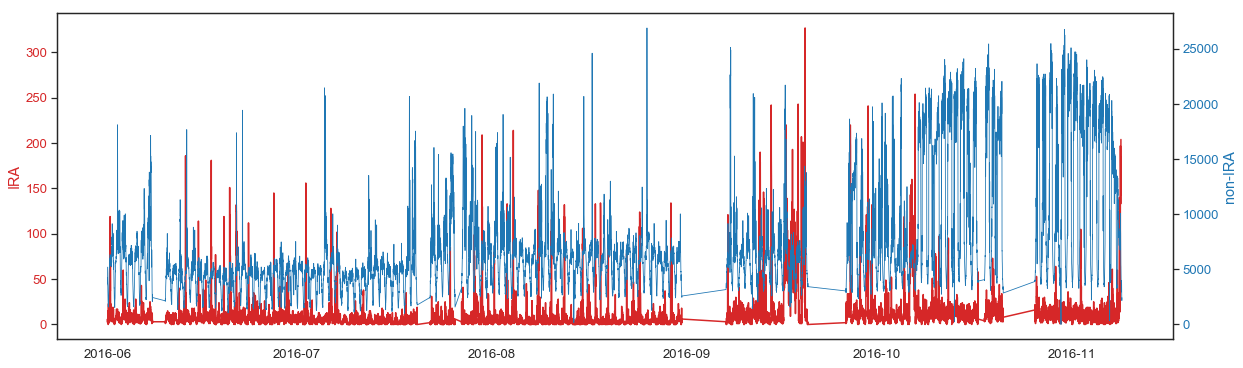

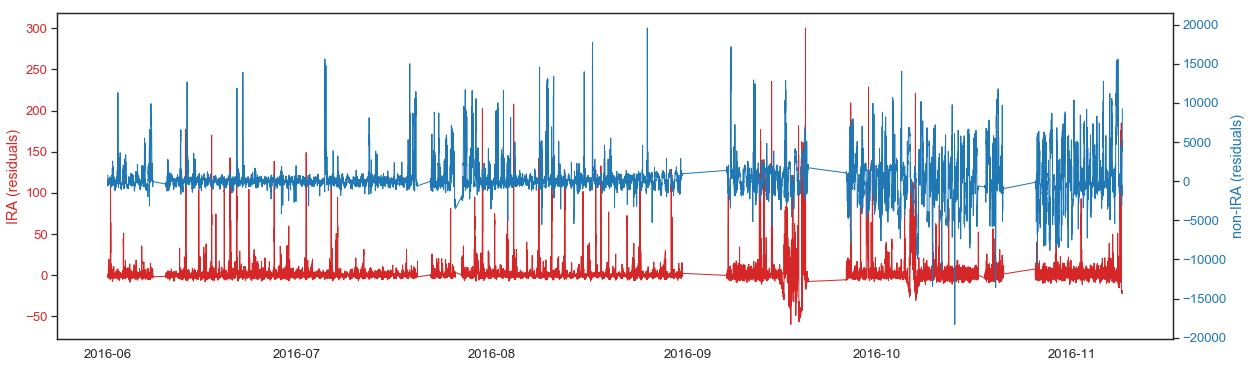

 ---------------------- IRA causes T influs ----------------------
lag=1 *15Mins	p-value=0.0101
 ---------------------- T influs supporters causes IRA ----------------------
lag=2 *15Mins	p-value=0.1397
 ---------------------- IRA causes C influs ----------------------
lag=9 *15Mins	p-value=0.5734
 ---------------------- C influs supporters causes IRA ----------------------
lag=11 *15Mins	p-value=0.4457
 ---------------------- IRA causes Trump non-influs ----------------------
lag=1 *15Mins	p-value=0.0637
 ---------------------- Trump non-influs supporters causes IRA ----------------------
lag=7 *15Mins	p-value=0.0027
 ---------------------- IRA causes Clinton non-influs ----------------------
lag=1 *15Mins	p-value=0.2094
 ---------------------- Clinton non-influs supporters causes IRA ----------------------
lag=5 *15Mins	p-value=0.0164
- * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * 
 ---------------------- influs causes Trump non-IRA non-influs -------

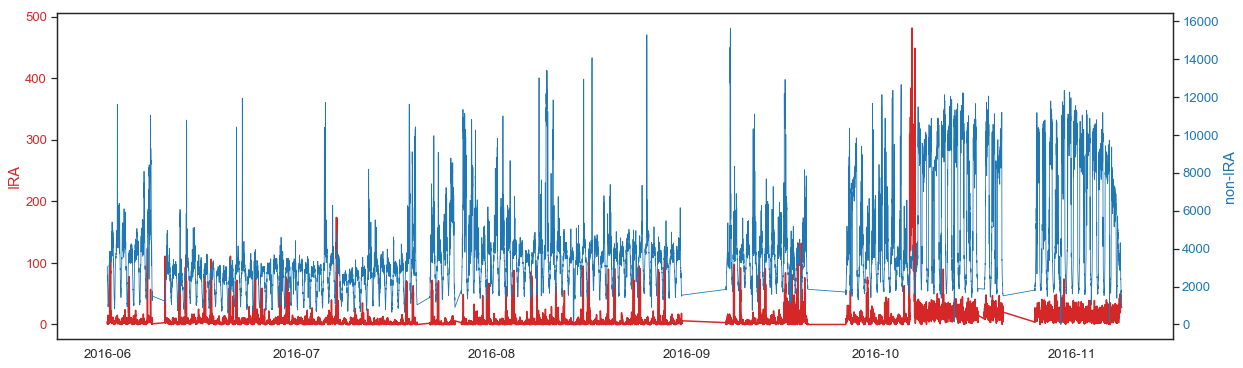

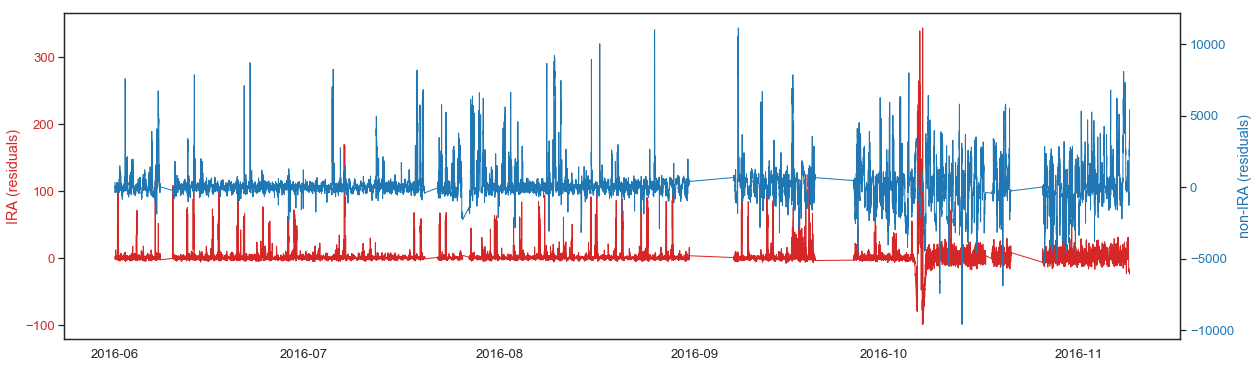

 ---------------------- IRA causes T influs ----------------------
lag=1 *15Mins	p-value=0.2786
 ---------------------- T influs supporters causes IRA ----------------------
lag=2 *15Mins	p-value=0.4939
 ---------------------- IRA causes C influs ----------------------
lag=1 *15Mins	p-value=0.2600
 ---------------------- C influs supporters causes IRA ----------------------
lag=3 *15Mins	p-value=0.3939
 ---------------------- IRA causes Trump non-influs ----------------------
lag=1 *15Mins	p-value=0.0324
 ---------------------- Trump non-influs supporters causes IRA ----------------------
lag=1 *15Mins	p-value=0.0525
 ---------------------- IRA causes Clinton non-influs ----------------------
lag=1 *15Mins	p-value=0.3361
 ---------------------- Clinton non-influs supporters causes IRA ----------------------
lag=2 *15Mins	p-value=0.2848
- * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * 
 ---------------------- influs causes Trump non-IRA non-influs --------

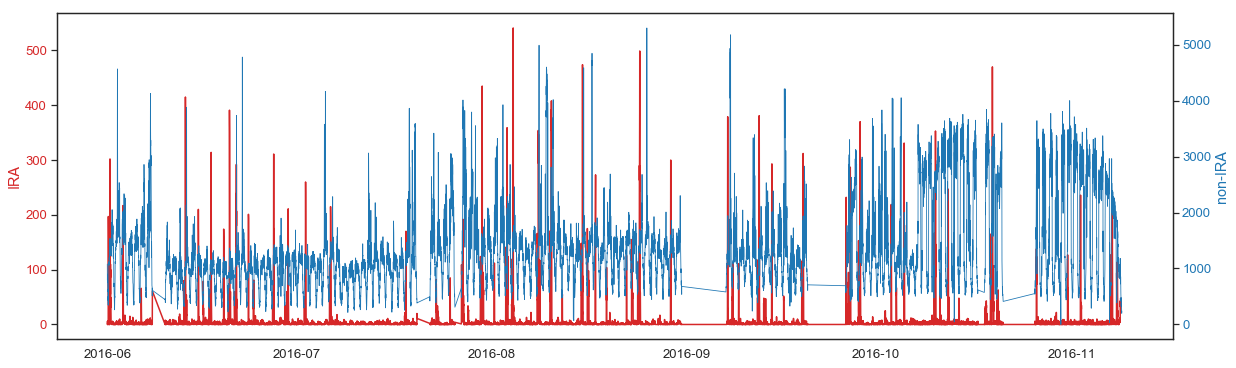

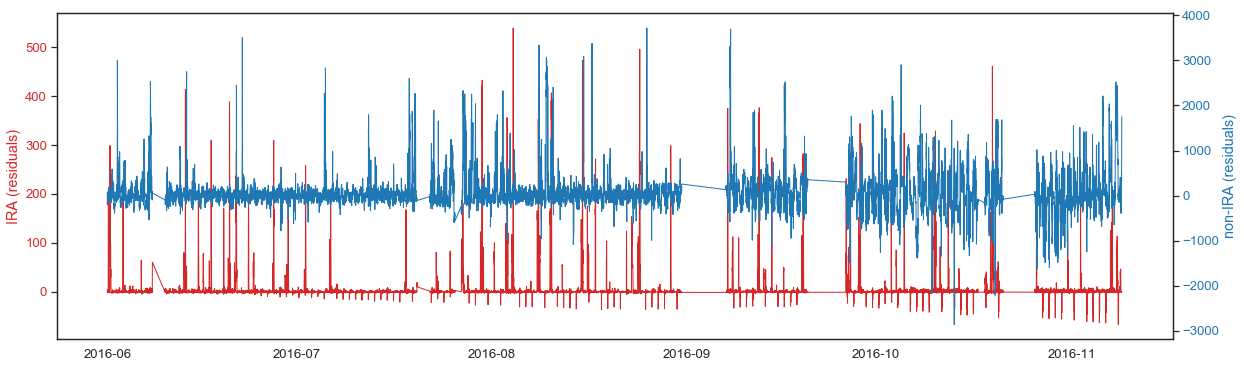

 ---------------------- IRA causes T influs ----------------------
lag=1 *15Mins	p-value=0.0257
 ---------------------- T influs supporters causes IRA ----------------------
lag=2 *15Mins	p-value=0.5483
 ---------------------- IRA causes C influs ----------------------
lag=9 *15Mins	p-value=0.0251
 ---------------------- C influs supporters causes IRA ----------------------
lag=2 *15Mins	p-value=0.1690
 ---------------------- IRA causes Trump non-influs ----------------------
lag=16 *15Mins	p-value=0.2949
 ---------------------- Trump non-influs supporters causes IRA ----------------------
lag=1 *15Mins	p-value=0.2861
 ---------------------- IRA causes Clinton non-influs ----------------------
lag=15 *15Mins	p-value=0.0008
 ---------------------- Clinton non-influs supporters causes IRA ----------------------
lag=1 *15Mins	p-value=0.2243
- * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * 
 ---------------------- influs causes Trump non-IRA non-influs ------

In [124]:
analyze_ts_of_communities(1, "two")
analyze_ts_of_communities(2, "two")
analyze_ts_of_communities(3, "two")

# 分析川普的支持者和希拉里的支持者上的因果关系

## 分析社团中的支持者 for Trump OR Clinton

In [207]:
comm = json.load(open("data/louvain_rst_4.json"))
putin = Are_you_IRA()

comm_1 = []
comm_2 = []
comm_3 = []
comm_4 = []

comm_1_ira = []
comm_2_ira = []
comm_3_ira = []
comm_4_ira = []

for uid, c in comm.items():
    if c == 0:
        if putin.check(uid):
            comm_1_ira.append(uid)
        else:
            comm_1.append(uid)
    elif c == 1:
        if putin.check(uid):
            comm_2_ira.append(uid)
        else:
            comm_2.append(uid)
    elif c == 3:
        if putin.check(uid):
            comm_3_ira.append(uid)
        else:
            comm_3.append(uid)
    elif c == 2:
        if putin.check(uid):
            comm_4_ira.append(uid)
        else:
            comm_4.append(uid)
        
len(comm_1), len(comm_2), len(comm_3), len(comm_4)
# len(comm_1_ira), len(comm_2_ira), len(comm_3_ira), len(comm_4_ira)
# len(comm_1_ira) + len(comm_2_ira) + len(comm_3_ira) + len(comm_4_ira)

(137811, 31714, 9530, 130)

In [184]:
user_support = json.load(open("disk/user_hillary_trump.json"))
len(user_support)

10941026

In [185]:
users_opinion = {}
opinion = Counter()

for uid, v in tqdm(user_support.items()):
    if v[0] > v[1]:
        users_opinion[uid] = "C"
        opinion["C"] += 1
    elif v[0] < v[1]:
        users_opinion[uid] = "T"
        opinion["T"] += 1
    else:
        users_opinion[uid] = "U"
        opinion["U"] += 1
        
opinion

Counter({'T': 3023112, 'C': 7113057, 'U': 804857})

In [50]:
def get_comm_opinion(c):
    opi = Counter()
    for _uid in c:
        if _uid in users_opinion:
            opi[users_opinion[_uid]] += 1
    print(opi)

print("社团中Trump的支持者和Clinton的支持者数量：")
get_comm_opinion(comm_1)
get_comm_opinion(comm_2)
get_comm_opinion(comm_3)

社团中Trump的支持者和Clinton的支持者数量：
Counter({'T': 115390, 'C': 16629, 'U': 2422})
Counter({'C': 19901, 'T': 4274, 'U': 1031})
Counter({'C': 5311, 'T': 1862, 'U': 395})


In [39]:
# from stldecompose import decompose, forecast

def analyze_ts_TC(cN, layer):
    # read
    tsts = pd.read_pickle(f"data/tsts/C{cN}-{layer}-layer.pickle")

    sns.set(style="white", font_scale=1.2)
    fig, ax1 = plt.subplots(figsize=(20, 6))
    color = 'tab:red'
    ax1.set_ylabel('IRA', color=color)  # we already handled the x-label with ax1
    ax1.plot("ts", data=tsts, color=color, label="IRA")
    ax1.tick_params(axis='y', labelcolor=color)
    
    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    ax2.set_ylabel('non-IRA')  # we already handled the x-label with ax1
    ax2.plot("T_ts", data=tsts, color='tab:green', alpha=0.7, lw=0.8, label="Trump supporters")
    ax2.plot("C_ts", data=tsts, color='tab:blue', alpha=0.7, lw=0.8, label="Clinton supporters")
    plt.savefig(f"fig/c{cN}-{layer}-layer-TC-ts.pdf", dpi=300)
    plt.legend()
    plt.show()
    plt.close()
    
    # read

    tsts_resid = pd.read_pickle(f"data/tsts/resid_C{cN}-{layer}-layer.pl")
    sns.set(style="white", font_scale=1.2)
    fig, ax1 = plt.subplots(figsize=(20, 6))
    color = 'tab:red'
    ax1.set_ylabel('IRA (residuals)', color=color)  # we already handled the x-label with ax1
    # ax1.set_ylim((-600, 600))
    ax1.plot("ts", data=tsts_resid, color=color, lw=1, label="IRA")
    ax1.tick_params(axis='y', labelcolor=color)
#     ax1.legend()
    
    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    ax2.set_ylabel("non-IRA (residuals)")  # we already handled the x-label with ax1
    # ax2.set_ylim((-20000, 20000))
    ax2.plot("T_ts", data=tsts_resid, color='tab:green', alpha=0.7, lw=1, label="Trump supporters")
    ax2.plot("C_ts", data=tsts_resid, color='tab:blue', alpha=0.7,  lw=1, label="Clinton supporters")
#     ax2.legend()

    plt.legend()
    
    plt.savefig(f"fig/c{cN}-{layer}-layer-TC-resid.pdf", dpi=300)
    plt.show()
    plt.close()
    
    # 因果分析
    from statsmodels.tsa.stattools import grangercausalitytests
    
    # print(tsts_resid.non_ts.dropna(), tsts_resid.ts.dropna())
    
    for_gra = np.array([tsts_resid.T_ts.dropna(), tsts_resid.ts.dropna()]).T
    # print(for_gra)
    print(" ---------------------- IRA causes Trump supporters ----------------------")
    r1 = grangercausalitytests(for_gra, maxlag=16, verbose=False)
    for _k, v in r1.items():
        print(f"lag={_k}\tF={v[0]['ssr_ftest'][0]:.4f}\tp-value={v[0]['ssr_ftest'][1]:.4f}")

    for_gra = np.array([tsts_resid.ts.dropna(), tsts_resid.T_ts.dropna()]).T
    print(" ---------------------- Trump supporters causes IRA ----------------------")
    r2 = grangercausalitytests(for_gra, maxlag=16, verbose=False)
    for _k, v in r2.items():
        print(f"lag={_k}\tF={v[0]['ssr_ftest'][0]:.4f}\tp-value={v[0]['ssr_ftest'][1]:.4f}")
              
    for_gra = np.array([tsts_resid.C_ts.dropna(), tsts_resid.ts.dropna()]).T
    # print(for_gra)
    print(" ---------------------- IRA causes Clinton supporters ----------------------")
    r1 = grangercausalitytests(for_gra, maxlag=16, verbose=False)
    for _k, v in r1.items():
        print(f"lag={_k}\tF={v[0]['ssr_ftest'][0]:.4f}\tp-value={v[0]['ssr_ftest'][1]:.4f}")

    for_gra = np.array([tsts_resid.ts.dropna(), tsts_resid.C_ts.dropna()]).T
    print(" ---------------------- Clinton supporters causes IRA ----------------------")
    r2 = grangercausalitytests(for_gra, maxlag=16, verbose=False)
    for _k, v in r2.items():
        print(f"lag={_k}\tF={v[0]['ssr_ftest'][0]:.4f}\tp-value={v[0]['ssr_ftest'][1]:.4f}")

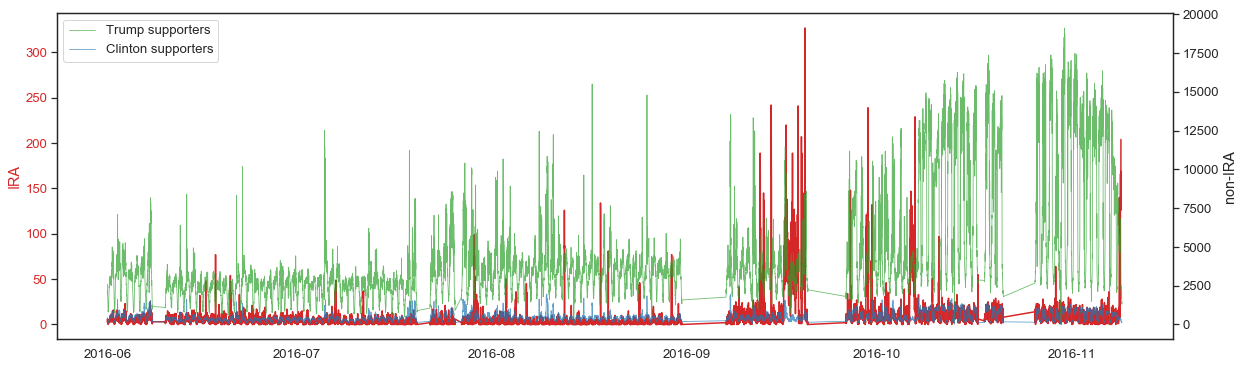

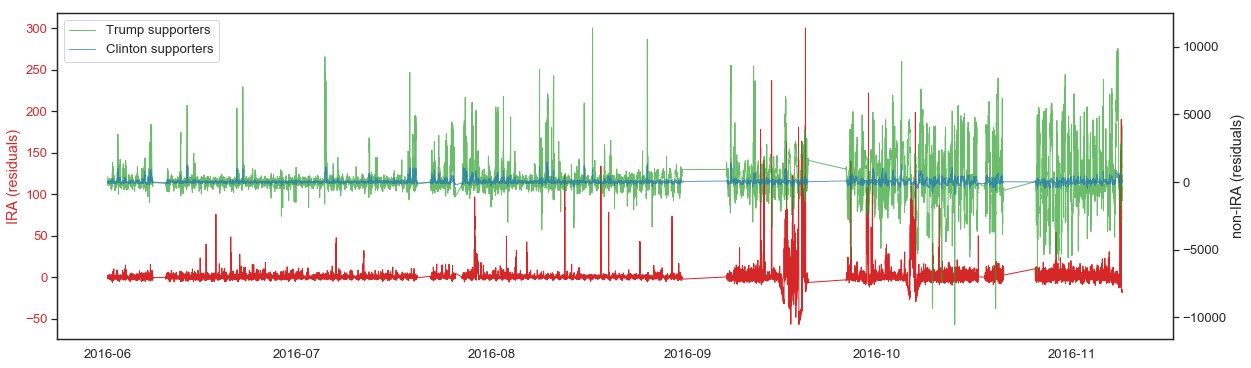

 ---------------------- IRA causes Trump supporters ----------------------
lag=1	F=3.5504	p-value=0.0596
lag=2	F=1.5209	p-value=0.2186
lag=3	F=1.4928	p-value=0.2143
lag=4	F=1.2151	p-value=0.3020
lag=5	F=1.1066	p-value=0.3544
lag=6	F=0.9755	p-value=0.4399
lag=7	F=0.9107	p-value=0.4968
lag=8	F=0.8367	p-value=0.5700
lag=9	F=0.7646	p-value=0.6495
lag=10	F=0.7235	p-value=0.7031
lag=11	F=0.7039	p-value=0.7361
lag=12	F=0.7184	p-value=0.7349
lag=13	F=0.7967	p-value=0.6645
lag=14	F=0.7580	p-value=0.7162
lag=15	F=0.7283	p-value=0.7579
lag=16	F=0.6864	p-value=0.8105
 ---------------------- Trump supporters causes IRA ----------------------
lag=1	F=1.3831	p-value=0.2396
lag=2	F=0.7362	p-value=0.4789
lag=3	F=0.7640	p-value=0.5141
lag=4	F=3.3285	p-value=0.0099
lag=5	F=4.6927	p-value=0.0003
lag=6	F=4.2371	p-value=0.0003
lag=7	F=4.1007	p-value=0.0002
lag=8	F=3.7868	p-value=0.0002
lag=9	F=3.3174	p-value=0.0005
lag=10	F=2.9916	p-value=0.0009
lag=11	F=2.7296	p-value=0.0016
lag=12	F=2.6937	p-value=0.0012


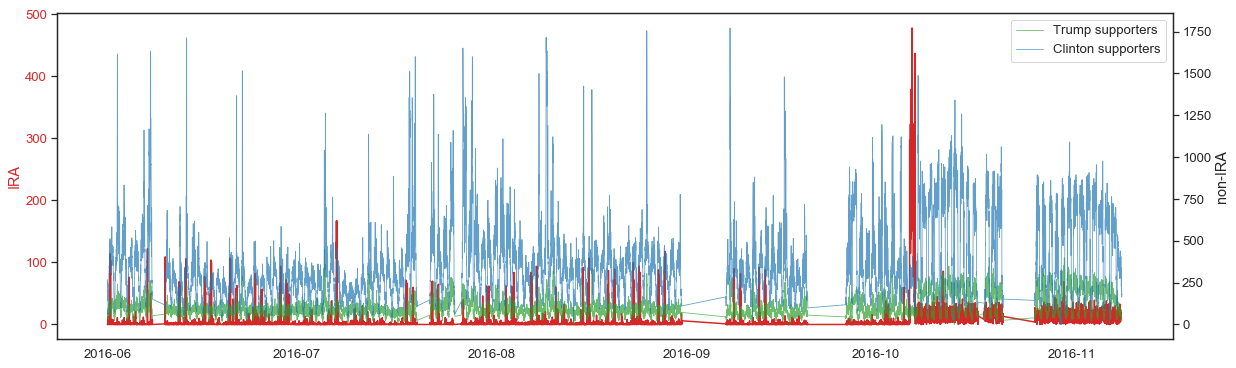

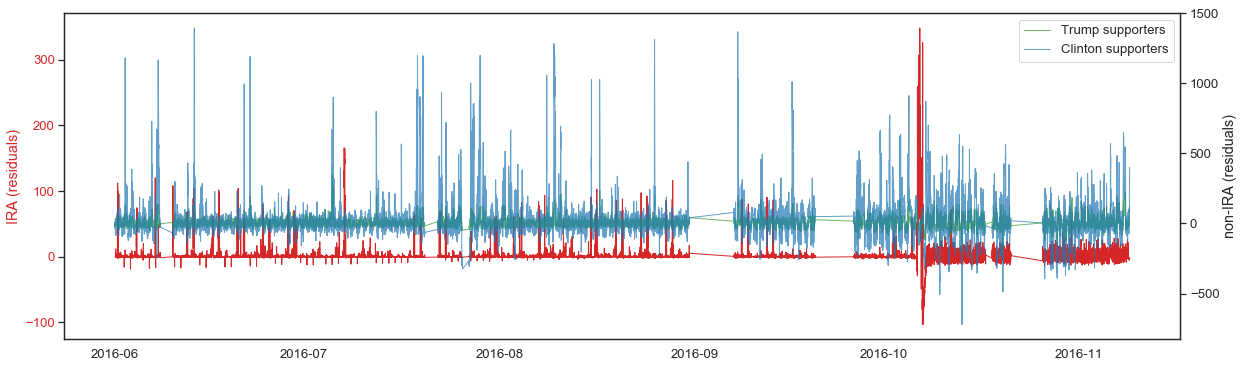

 ---------------------- IRA causes Trump supporters ----------------------
lag=1	F=2.9446	p-value=0.0862
lag=2	F=1.8346	p-value=0.1597
lag=3	F=1.1799	p-value=0.3157
lag=4	F=0.9696	p-value=0.4227
lag=5	F=0.8337	p-value=0.5254
lag=6	F=0.6979	p-value=0.6514
lag=7	F=0.5979	p-value=0.7582
lag=8	F=0.5735	p-value=0.8005
lag=9	F=0.5828	p-value=0.8124
lag=10	F=0.5289	p-value=0.8710
lag=11	F=0.4872	p-value=0.9125
lag=12	F=0.4742	p-value=0.9308
lag=13	F=0.4442	p-value=0.9539
lag=14	F=0.5035	p-value=0.9327
lag=15	F=0.6141	p-value=0.8661
lag=16	F=0.6415	p-value=0.8524
 ---------------------- Trump supporters causes IRA ----------------------
lag=1	F=0.3166	p-value=0.5737
lag=2	F=1.0124	p-value=0.3634
lag=3	F=0.3925	p-value=0.7584
lag=4	F=0.3111	p-value=0.8707
lag=5	F=0.2644	p-value=0.9327
lag=6	F=0.3037	p-value=0.9353
lag=7	F=0.2958	p-value=0.9558
lag=8	F=0.2990	p-value=0.9666
lag=9	F=0.3444	p-value=0.9602
lag=10	F=0.3504	p-value=0.9670
lag=11	F=0.4588	p-value=0.9288
lag=12	F=0.4908	p-value=0.9215


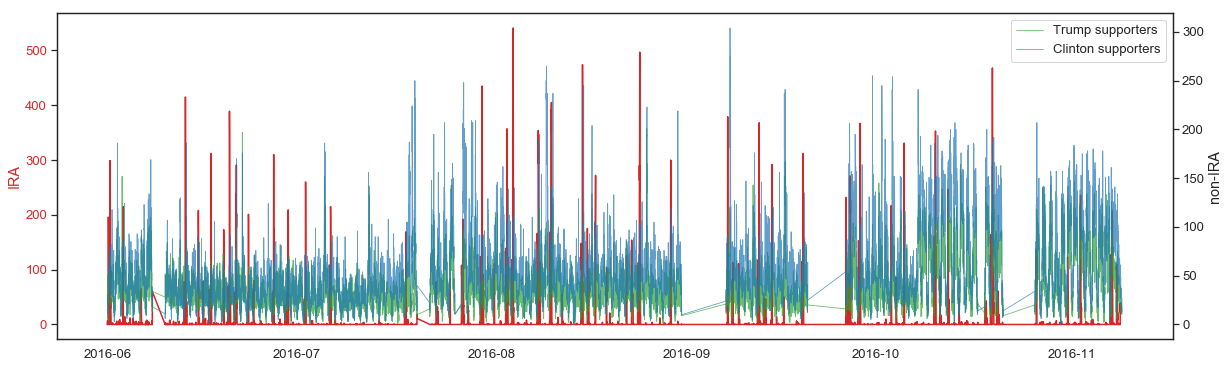

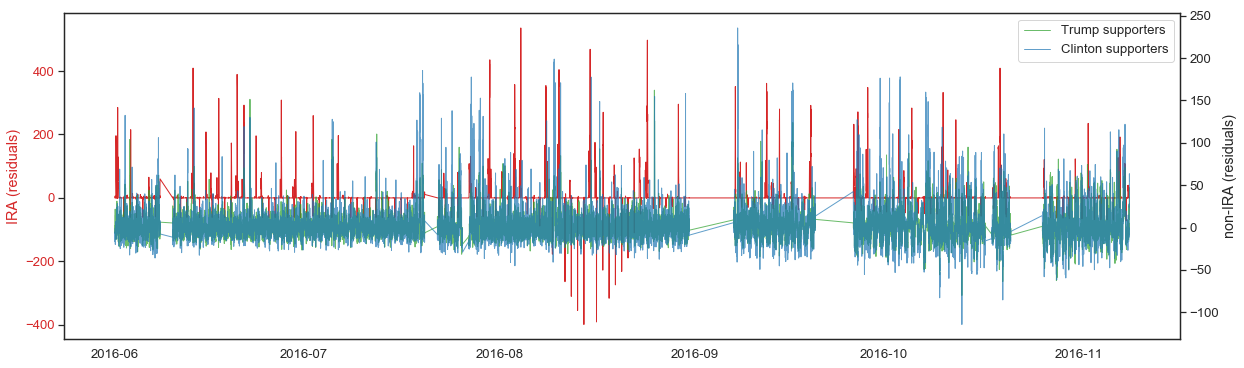

 ---------------------- IRA causes Trump supporters ----------------------
lag=1	F=0.0838	p-value=0.7722
lag=2	F=0.4312	p-value=0.6498
lag=3	F=0.4650	p-value=0.7067
lag=4	F=0.4581	p-value=0.7666
lag=5	F=0.6358	p-value=0.6724
lag=6	F=0.5659	p-value=0.7578
lag=7	F=1.0431	p-value=0.3983
lag=8	F=1.5669	p-value=0.1290
lag=9	F=1.4622	p-value=0.1557
lag=10	F=1.4492	p-value=0.1519
lag=11	F=1.3168	p-value=0.2075
lag=12	F=1.2231	p-value=0.2597
lag=13	F=1.5723	p-value=0.0849
lag=14	F=1.5393	p-value=0.0885
lag=15	F=1.4594	p-value=0.1109
lag=16	F=1.4293	p-value=0.1175
 ---------------------- Trump supporters causes IRA ----------------------
lag=1	F=1.2815	p-value=0.2576
lag=2	F=0.7303	p-value=0.4818
lag=3	F=1.2560	p-value=0.2877
lag=4	F=1.0429	p-value=0.3833
lag=5	F=0.8374	p-value=0.5229
lag=6	F=0.7093	p-value=0.6421
lag=7	F=0.6223	p-value=0.7379
lag=8	F=0.7019	p-value=0.6902
lag=9	F=0.5950	p-value=0.8023
lag=10	F=0.8091	p-value=0.6200
lag=11	F=0.9258	p-value=0.5140
lag=12	F=0.8832	p-value=0.5636


In [40]:
analyze_ts_TC(1, "one")
analyze_ts_TC(2, "one")
analyze_ts_TC(3, "one")

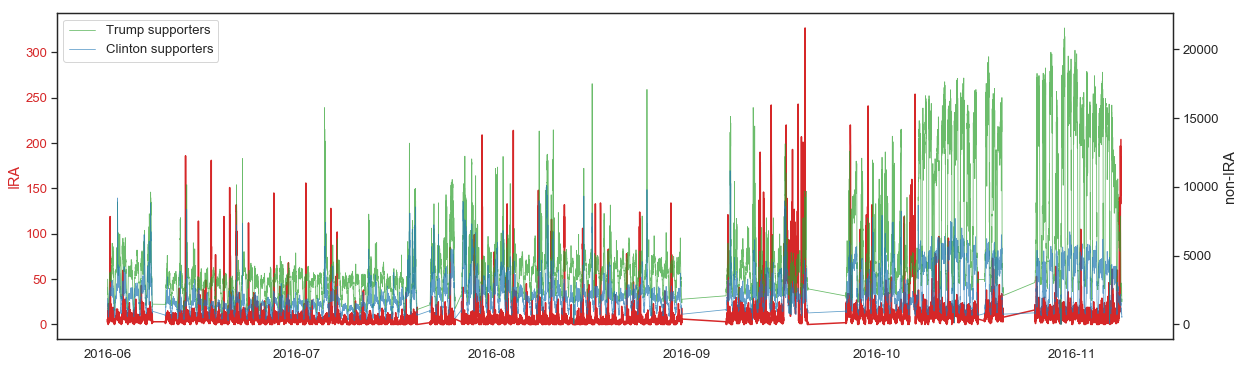

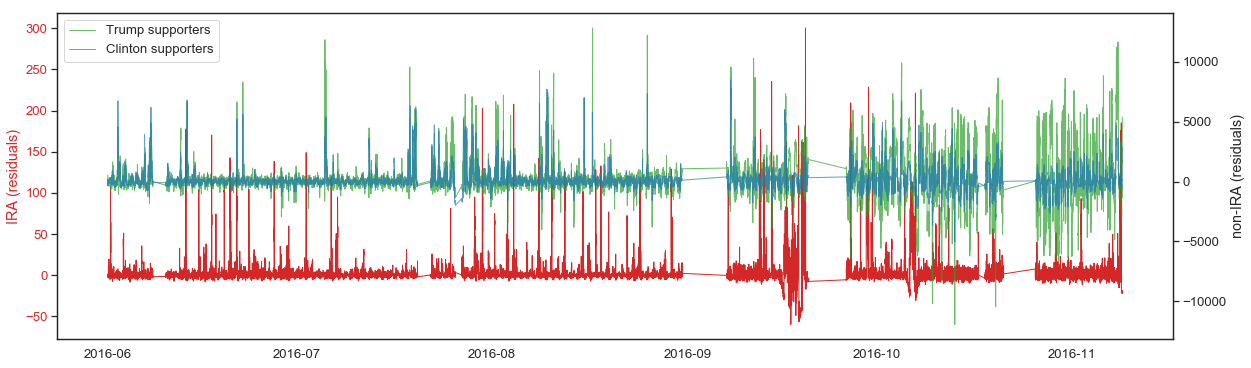

 ---------------------- IRA causes Trump supporters ----------------------
lag=1	F=3.4735	p-value=0.0624
lag=2	F=1.7397	p-value=0.1756
lag=3	F=1.4088	p-value=0.2381
lag=4	F=1.0241	p-value=0.3931
lag=5	F=0.8616	p-value=0.5060
lag=6	F=0.9235	p-value=0.4765
lag=7	F=0.7519	p-value=0.6279
lag=8	F=0.6701	p-value=0.7184
lag=9	F=0.7210	p-value=0.6901
lag=10	F=0.6624	p-value=0.7604
lag=11	F=0.6899	p-value=0.7495
lag=12	F=0.6744	p-value=0.7778
lag=13	F=0.6827	p-value=0.7822
lag=14	F=0.7378	p-value=0.7377
lag=15	F=0.7213	p-value=0.7652
lag=16	F=0.7644	p-value=0.7280
 ---------------------- Trump supporters causes IRA ----------------------
lag=1	F=2.3169	p-value=0.1280
lag=2	F=1.0209	p-value=0.3603
lag=3	F=0.9633	p-value=0.4090
lag=4	F=2.9590	p-value=0.0186
lag=5	F=3.2469	p-value=0.0062
lag=6	F=3.3241	p-value=0.0028
lag=7	F=3.1236	p-value=0.0027
lag=8	F=2.9067	p-value=0.0031
lag=9	F=2.6078	p-value=0.0053
lag=10	F=2.3444	p-value=0.0093
lag=11	F=2.1879	p-value=0.0125
lag=12	F=2.2140	p-value=0.0090


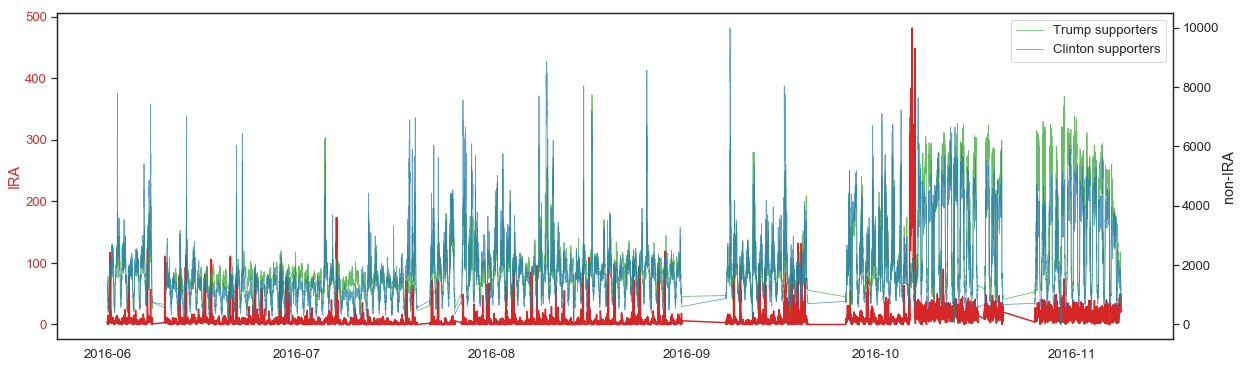

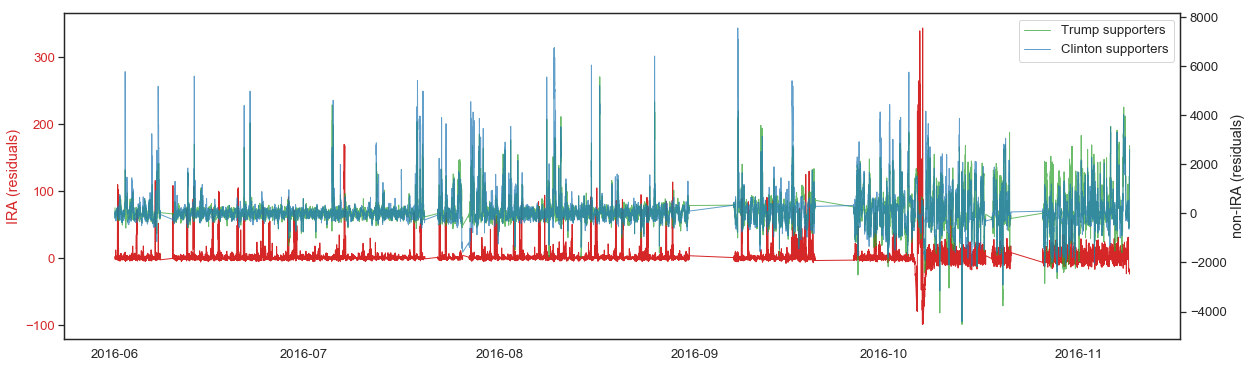

 ---------------------- IRA causes Trump supporters ----------------------
lag=1	F=4.5524	p-value=0.0329
lag=2	F=1.8848	p-value=0.1519
lag=3	F=1.3165	p-value=0.2670
lag=4	F=1.0895	p-value=0.3598
lag=5	F=0.8878	p-value=0.4882
lag=6	F=0.9682	p-value=0.4449
lag=7	F=0.8570	p-value=0.5399
lag=8	F=0.7882	p-value=0.6131
lag=9	F=0.7041	p-value=0.7058
lag=10	F=0.6584	p-value=0.7641
lag=11	F=0.5891	p-value=0.8395
lag=12	F=0.5432	p-value=0.8877
lag=13	F=0.5014	p-value=0.9252
lag=14	F=0.4736	p-value=0.9480
lag=15	F=0.5488	p-value=0.9141
lag=16	F=0.6281	p-value=0.8640
 ---------------------- Trump supporters causes IRA ----------------------
lag=1	F=3.7062	p-value=0.0542
lag=2	F=1.7050	p-value=0.1818
lag=3	F=1.5607	p-value=0.1967
lag=4	F=1.3154	p-value=0.2616
lag=5	F=1.0433	p-value=0.3901
lag=6	F=0.9952	p-value=0.4265
lag=7	F=0.9092	p-value=0.4979
lag=8	F=0.8874	p-value=0.5260
lag=9	F=0.8059	p-value=0.6108
lag=10	F=0.7386	p-value=0.6885
lag=11	F=0.7662	p-value=0.6744
lag=12	F=0.7887	p-value=0.6628


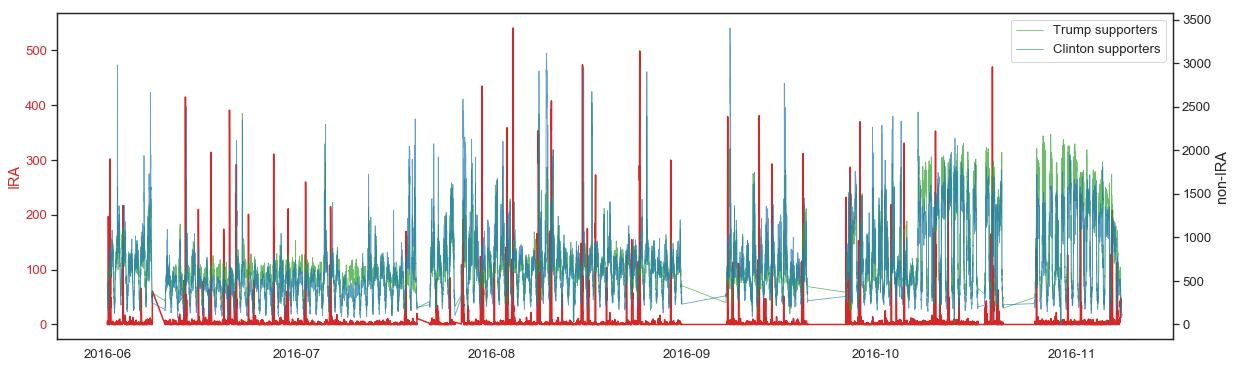

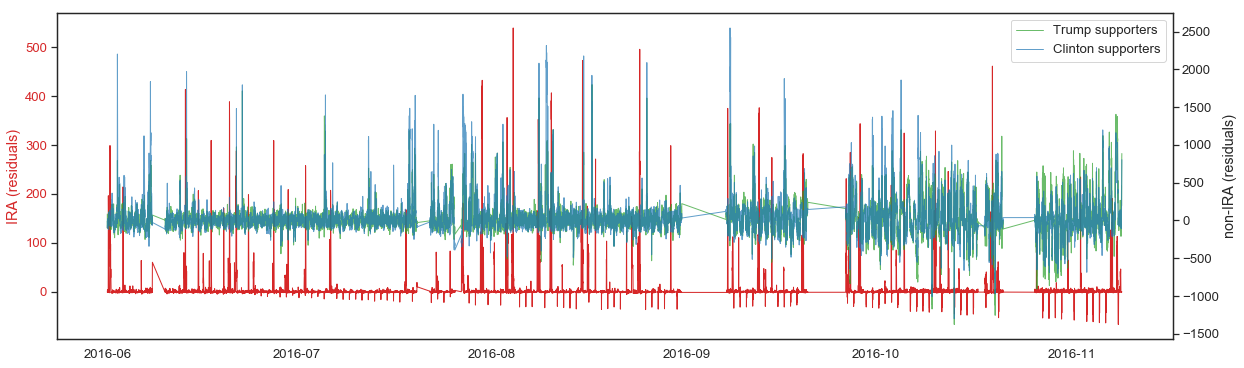

 ---------------------- IRA causes Trump supporters ----------------------
lag=1	F=0.6409	p-value=0.4234
lag=2	F=0.1529	p-value=0.8582
lag=3	F=0.1438	p-value=0.9337
lag=4	F=0.4810	p-value=0.7497
lag=5	F=0.5166	p-value=0.7639
lag=6	F=0.4284	p-value=0.8605
lag=7	F=0.4473	p-value=0.8726
lag=8	F=0.5591	p-value=0.8121
lag=9	F=0.5582	p-value=0.8322
lag=10	F=0.8589	p-value=0.5715
lag=11	F=0.7788	p-value=0.6618
lag=12	F=0.7537	p-value=0.6991
lag=13	F=0.9457	p-value=0.5037
lag=14	F=1.0066	p-value=0.4429
lag=15	F=0.9481	p-value=0.5089
lag=16	F=1.0865	p-value=0.3613
 ---------------------- Trump supporters causes IRA ----------------------
lag=1	F=1.2358	p-value=0.2663
lag=2	F=0.8381	p-value=0.4325
lag=3	F=0.5747	p-value=0.6316
lag=4	F=0.7915	p-value=0.5304
lag=5	F=0.8399	p-value=0.5211
lag=6	F=0.8901	p-value=0.5010
lag=7	F=0.7757	p-value=0.6076
lag=8	F=1.0766	p-value=0.3761
lag=9	F=1.0707	p-value=0.3808
lag=10	F=1.0510	p-value=0.3970
lag=11	F=1.1137	p-value=0.3452
lag=12	F=1.1636	p-value=0.3032


In [29]:
analyze_ts_TC(1, "two")
analyze_ts_TC(2, "two")
analyze_ts_TC(3, "two")

In [47]:
# from stldecompose import decompose, forecast
sns.set(style="ticks", font_scale=1.2)
import matplotlib.dates as mdates
from datetime import datetime

def analyze_ts_C(cN, layer):
    # read
    tsts = pd.read_pickle(f"data/tsts/C{cN}-{layer}-layer.pickle")
    
    fig, ax1 = plt.subplots(figsize=(20, 5))
    color = 'tab:red'
    ax1.set_ylabel('IRA', color=color)  # we already handled the x-label with ax1
    ax1.plot("ts", data=tsts, color=color, label="IRA", lw=2)
    ax1.tick_params(axis='y', labelcolor=color)
    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    ax2.set_ylabel('Clinton supporters', color="tab:blue")  # we already handled the x-label with ax1
#     ax2.plot("T_ts", data=tsts, color='tab:green', alpha=0.7, lw=0.8, label="Trump supporters")
    ax2.plot("C_ts", data=tsts, color='tab:blue', lw=1, label="Clinton supporters")
    plt.savefig(f"fig/c{cN}-{layer}-layer-C-ts.pdf", dpi=300)
    plt.xlim(datetime(2016, 9, 7), datetime(2016, 9, 10))
    plt.show()
    plt.close()

    tsts_resid = pd.read_pickle(f"data/tsts/resid_C{cN}-{layer}-layer.pl")
    fig, ax1 = plt.subplots(figsize=(10, 5))
    color = 'tab:red'
    ax1.set_ylabel('IRA (residuals)', color=color)  # we already handled the x-label with ax1
    ax1.set_ylim((-30, 150))
    ax1.plot("ts", data=tsts_resid, color=color, lw=2, label="IRA")
    ax1.tick_params(axis='y', labelcolor=color)
#     ax1.legend()
    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    ax2.set_ylabel('Clinton supporters (residuals)', color="tab:blue")  # we already handled the x-label with ax1
    ax2.set_ylim((-2000, 10000))
    # ax2.plot("T_ts", data=tsts_resid, color='tab:green', alpha=0.7, lw=1, label="Trump supporters")
    ax2.plot("C_ts", data=tsts_resid, color='tab:blue', lw=1, label="Clinton supporters")

    plt.xlim(datetime(2016, 9, 7), datetime(2016, 9, 12))
#     plt.xlim(datetime(2016, 10, 7), datetime(2016, 10, 10))
    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %HH'))
    fig.autofmt_xdate()
    plt.savefig(f"fig/c{cN}-{layer}-layer-C-resid.pdf", dpi=300)
    # plt.show()
    plt.close()

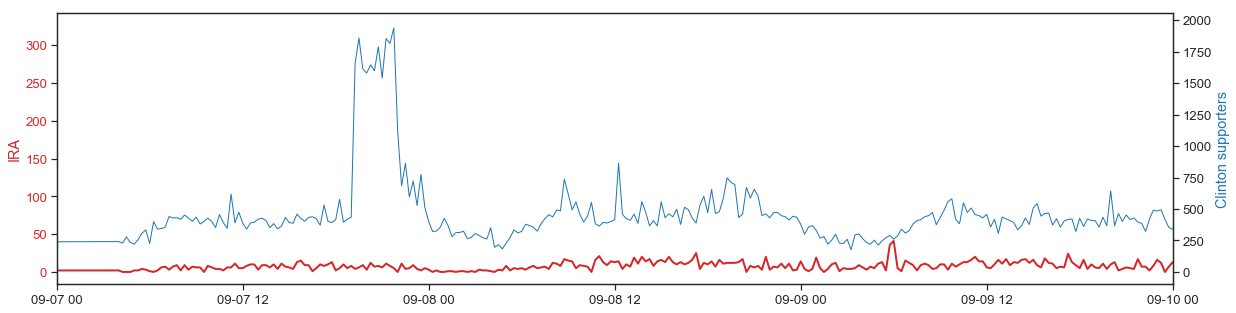

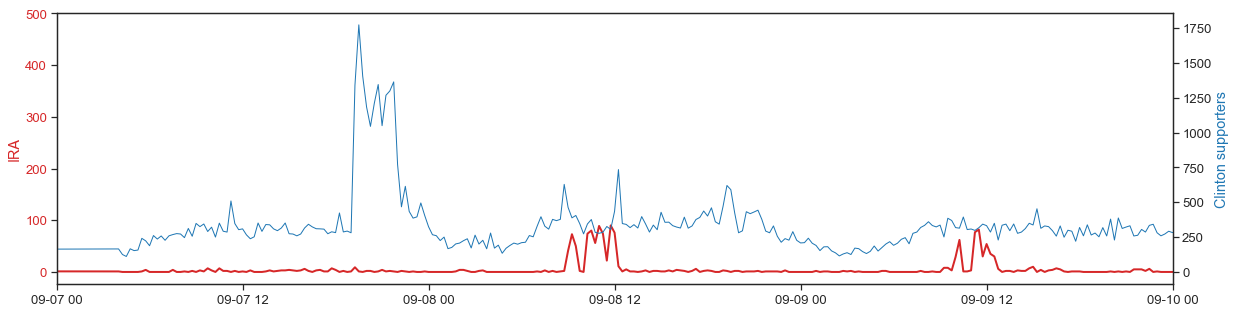

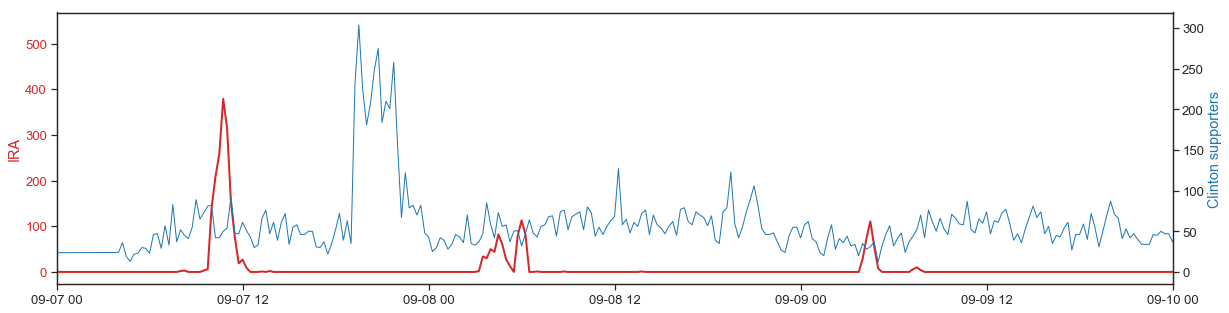

In [48]:
analyze_ts_C(1, "one")
analyze_ts_C(2, "one")
analyze_ts_C(3, "one")

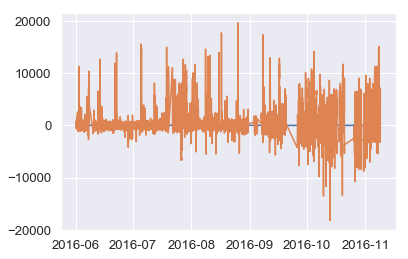

In [21]:
dftrend = pd.DataFrame(index=tsts.index)
dfseasonal = pd.DataFrame(index=tsts.index)
dfresiduals = pd.DataFrame(index=tsts.index)

for col in stl_res_dict.keys():
    dftrend[col] = stl_res_dict[col].trend
    dfseasonal[col] = stl_res_dict[col].seasonal
    dfresiduals[col] = stl_res_dict[col].residuals

tsts["non_ts"]
plt.plot(dfresiduals)

## Assortativity of two-layer network

不同类型节点的网络关系

Compute the assortativeity based on https://www.pnas.org/content/115/16/4057

In [49]:
def get_the_first_layer(G):
    set_nodes = set()
    for e in G.edges():
        s, t = G.nodes[e[0]]['IRA'], G.nodes[e[1]]['IRA']
        if s == 1 or t == 1:
            # _G.add_edge(*e)
            set_nodes.add(e[0])
            set_nodes.add(e[1])
            
    _G = G.subgraph(set_nodes)
    return _G


def compute_M(G, sub=False):
    
    IRA_list = []
    for n in G.nodes:
        if Putin.check(n):
            G.nodes[n]["IRA"] = 1
            IRA_list.append(n)
            # print(G.nodes[n])
        else:
            G.nodes[n]["IRA"] = 0
                
                
    if sub:
        G = get_the_first_layer(G)
        for n in G.nodes:
            if Putin.check(n):
                G.nodes[n]["IRA"] = 1
                IRA_list.append(n)
                # print(G.nodes[n])
            else:
                G.nodes[n]["IRA"] = 0
    
    e00 = 0
    e01 = 0
    e10 = 0
    e11 = 0

    _2_m = 0
    for e in G.edges():
        s, t = G.nodes[e[0]]['IRA'], G.nodes[e[1]]['IRA']
        if s == 0 and t == 0:
            e00 += 1
        elif s == 0 and t == 1:
            e01 += 1
        elif s == 1 and t == 0:
            e10 += 1
        elif s == 1 and t == 1:
            e11 += 1
        else:
            print('error!')
        _2_m += 1
    _2_m *= 2
            
    E00 = e00 / _2_m
    E01 = e01 / _2_m
    E10 = e10 / _2_m
    E11 = e11 / _2_m
    
    M = (E11 + E00 - 2 * E01 * E10) / (1 - 2 * E01 * E10)
    print("non-IRA > non-IRA:", e00)
    print("non-IRA > IRA:", e01)
    print("IRA > non-IRA:", e10)
    print("IRA > IRA", e11)
    print("r_global:", M)
    print("nx.attribute_assortativity_coefficient:", nx.attribute_assortativity_coefficient(G, "IRA"))
    return M

In [52]:
G1 = nx.read_gpickle("data/graph/C1-two-layer.gpickle")
G2 = nx.read_gpickle("data/graph/C2-two-layer.gpickle")
G3 = nx.read_gpickle("data/graph/C3-two-layer.gpickle")
G1.number_of_nodes(), G2.number_of_nodes(), G3.number_of_nodes()

(316046, 100741, 24914)

In [50]:
compute_M(G1)
compute_M(G2)
compute_M(G3)

non-IRA > non-IRA: 7124046
non-IRA > IRA: 40856
IRA > non-IRA: 241053
IRA > IRA 393
r_global: 0.4809218230697027
nx.attribute_assortativity_coefficient: -0.006797808476201691
non-IRA > non-IRA: 339202
non-IRA > IRA: 63632
IRA > non-IRA: 7352
IRA > IRA 777
r_global: 0.41282376275424254
nx.attribute_assortativity_coefficient: -0.014203009027480508
non-IRA > non-IRA: 42745
non-IRA > IRA: 46183
IRA > non-IRA: 467
IRA > IRA 1389
r_global: 0.2420797810040351
nx.attribute_assortativity_coefficient: 0.017540298233040347


0.2420797810040351

In [51]:
compute_M(G1, sub=True)
compute_M(G2, sub=True)
compute_M(G3, sub=True)

non-IRA > non-IRA: 5702124
non-IRA > IRA: 40856
IRA > non-IRA: 241053
IRA > IRA 393
r_global: 0.47637444918899363
nx.attribute_assortativity_coefficient: -0.009100736884205
non-IRA > non-IRA: 109503
non-IRA > IRA: 63632
IRA > non-IRA: 7352
IRA > IRA 777
r_global: 0.29920815290443287
nx.attribute_assortativity_coefficient: -0.06325544023209631
non-IRA > non-IRA: 4517
non-IRA > IRA: 46183
IRA > non-IRA: 467
IRA > IRA 1389
r_global: 0.05248847609515294
nx.attribute_assortativity_coefficient: -0.012633123559581608


0.05248847609515294